# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

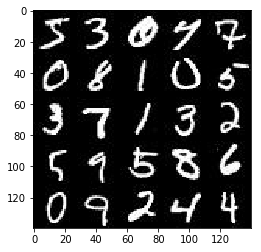

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

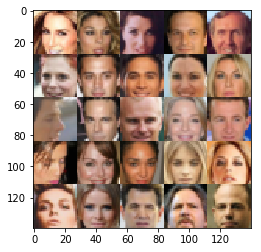

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/kazu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(
            tf.float32, [None, image_height, image_width, image_channels], name='real_input_images')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
from functools import reduce

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.08
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='SAME')
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, filters=128, kernel_size=5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(x2, filters=256, kernel_size=5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Flatten
        flat = tf.reshape(x3, (-1, reduce(lambda x, y: x*y, x3.get_shape().as_list()[1:])))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    reuse = not is_train
    alpha = 0.1
    keep_prob = 0.5
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # Fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=4, strides=1, padding='VALID')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        # 14x14x256 now
        
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5,
                                            strides=2, padding='SAME')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                    logits=d_logits_real,
                                    labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                    logits=d_logits_fake,
                                    labels=tf.zeros_like(d_model_real)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                    logits=d_logits_fake,
                                    labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,
                                             beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,
                                             beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    file_write = tf.summary.FileWriter('./logs/1', sess.graph)

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    print_every = 10
    show_every = 100
    
    out_channel_dim = data_shape[3]
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Scale to match our model
                batch_images = batch_images * 2
                
                # Run optimizers
                sess.run(d_opt, {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(g_opt, {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                # Get the losses and print them out
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    batch_num_denominator = data_shape[0] // batch_size
                    current_batch = steps - epoch_i * batch_num_denominator
                    
                    print("Epoch {}/{}".format(epoch_i+1, epoch_count),
                          "Batch {}/{}...".format(current_batch,
                                                  batch_num_denominator),
                          "Discriminator Loss: {:.4f}".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                # Show generated image
                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z,
                                          out_channel_dim, data_image_mode)

        print("Finished!")
        show_generator_output(sess, show_n_images, input_z, out_channel_dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Batch 10/1875... Discriminator Loss: 0.4362 Generator Loss: 1.6071
Epoch 1/2 Batch 20/1875... Discriminator Loss: 0.5802 Generator Loss: 1.4013
Epoch 1/2 Batch 30/1875... Discriminator Loss: 0.5451 Generator Loss: 10.3750
Epoch 1/2 Batch 40/1875... Discriminator Loss: 1.2270 Generator Loss: 0.5884
Epoch 1/2 Batch 50/1875... Discriminator Loss: 0.0322 Generator Loss: 5.8455
Epoch 1/2 Batch 60/1875... Discriminator Loss: 0.1420 Generator Loss: 2.8702
Epoch 1/2 Batch 70/1875... Discriminator Loss: 0.2141 Generator Loss: 1.8317
Epoch 1/2 Batch 80/1875... Discriminator Loss: 0.0624 Generator Loss: 3.5898
Epoch 1/2 Batch 90/1875... Discriminator Loss: 0.0485 Generator Loss: 4.4167
Epoch 1/2 Batch 100/1875... Discriminator Loss: 0.2523 Generator Loss: 2.3768


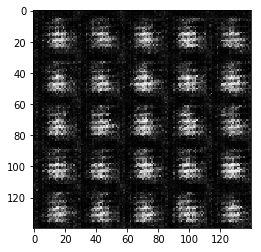

Epoch 1/2 Batch 110/1875... Discriminator Loss: 0.0122 Generator Loss: 5.2394
Epoch 1/2 Batch 120/1875... Discriminator Loss: 0.0307 Generator Loss: 4.1059
Epoch 1/2 Batch 130/1875... Discriminator Loss: 0.1403 Generator Loss: 9.0453
Epoch 1/2 Batch 140/1875... Discriminator Loss: 0.0708 Generator Loss: 4.2416
Epoch 1/2 Batch 150/1875... Discriminator Loss: 0.1663 Generator Loss: 7.1807
Epoch 1/2 Batch 160/1875... Discriminator Loss: 0.1549 Generator Loss: 4.3824
Epoch 1/2 Batch 170/1875... Discriminator Loss: 0.5503 Generator Loss: 1.6792
Epoch 1/2 Batch 180/1875... Discriminator Loss: 0.4777 Generator Loss: 3.2154
Epoch 1/2 Batch 190/1875... Discriminator Loss: 0.4435 Generator Loss: 2.7026
Epoch 1/2 Batch 200/1875... Discriminator Loss: 0.2179 Generator Loss: 4.8273


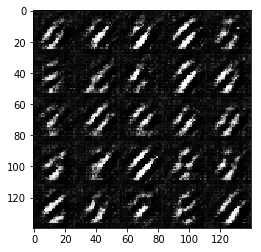

Epoch 1/2 Batch 210/1875... Discriminator Loss: 0.8121 Generator Loss: 1.8420
Epoch 1/2 Batch 220/1875... Discriminator Loss: 0.1563 Generator Loss: 3.1482
Epoch 1/2 Batch 230/1875... Discriminator Loss: 0.1835 Generator Loss: 3.5436
Epoch 1/2 Batch 240/1875... Discriminator Loss: 0.2623 Generator Loss: 2.5510
Epoch 1/2 Batch 250/1875... Discriminator Loss: 0.5370 Generator Loss: 2.3950
Epoch 1/2 Batch 260/1875... Discriminator Loss: 0.2622 Generator Loss: 2.9389
Epoch 1/2 Batch 270/1875... Discriminator Loss: 0.2387 Generator Loss: 3.0471
Epoch 1/2 Batch 280/1875... Discriminator Loss: 0.3890 Generator Loss: 1.7519
Epoch 1/2 Batch 290/1875... Discriminator Loss: 0.1763 Generator Loss: 2.9360
Epoch 1/2 Batch 300/1875... Discriminator Loss: 0.1359 Generator Loss: 3.4149


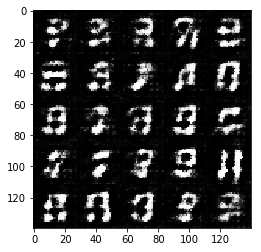

Epoch 1/2 Batch 310/1875... Discriminator Loss: 0.1317 Generator Loss: 2.8892
Epoch 1/2 Batch 320/1875... Discriminator Loss: 1.5201 Generator Loss: 0.3715
Epoch 1/2 Batch 330/1875... Discriminator Loss: 0.4729 Generator Loss: 1.5699
Epoch 1/2 Batch 340/1875... Discriminator Loss: 0.5232 Generator Loss: 1.8638
Epoch 1/2 Batch 350/1875... Discriminator Loss: 0.2076 Generator Loss: 3.0742
Epoch 1/2 Batch 360/1875... Discriminator Loss: 0.4637 Generator Loss: 2.1536
Epoch 1/2 Batch 370/1875... Discriminator Loss: 0.3075 Generator Loss: 3.9461
Epoch 1/2 Batch 380/1875... Discriminator Loss: 0.7669 Generator Loss: 1.2816
Epoch 1/2 Batch 390/1875... Discriminator Loss: 0.3240 Generator Loss: 2.1732
Epoch 1/2 Batch 400/1875... Discriminator Loss: 0.2704 Generator Loss: 2.1434


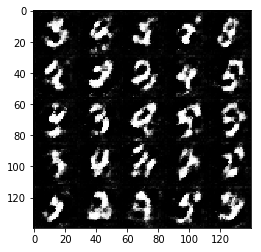

Epoch 1/2 Batch 410/1875... Discriminator Loss: 2.0894 Generator Loss: 0.1980
Epoch 1/2 Batch 420/1875... Discriminator Loss: 0.2257 Generator Loss: 2.6080
Epoch 1/2 Batch 430/1875... Discriminator Loss: 0.6460 Generator Loss: 1.4229
Epoch 1/2 Batch 440/1875... Discriminator Loss: 0.4417 Generator Loss: 1.9055
Epoch 1/2 Batch 450/1875... Discriminator Loss: 0.4253 Generator Loss: 2.3212
Epoch 1/2 Batch 460/1875... Discriminator Loss: 0.4913 Generator Loss: 2.3786
Epoch 1/2 Batch 470/1875... Discriminator Loss: 0.4033 Generator Loss: 2.1102
Epoch 1/2 Batch 480/1875... Discriminator Loss: 0.8278 Generator Loss: 3.9970
Epoch 1/2 Batch 490/1875... Discriminator Loss: 0.6065 Generator Loss: 1.9916
Epoch 1/2 Batch 500/1875... Discriminator Loss: 0.3877 Generator Loss: 2.3181


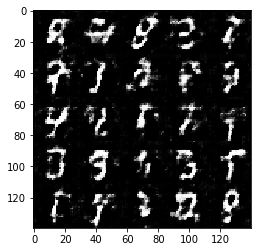

Epoch 1/2 Batch 510/1875... Discriminator Loss: 0.4660 Generator Loss: 1.6163
Epoch 1/2 Batch 520/1875... Discriminator Loss: 0.2409 Generator Loss: 2.6359
Epoch 1/2 Batch 530/1875... Discriminator Loss: 0.2949 Generator Loss: 2.3044
Epoch 1/2 Batch 540/1875... Discriminator Loss: 0.4130 Generator Loss: 2.7680
Epoch 1/2 Batch 550/1875... Discriminator Loss: 0.4296 Generator Loss: 1.8674
Epoch 1/2 Batch 560/1875... Discriminator Loss: 0.3224 Generator Loss: 2.5420
Epoch 1/2 Batch 570/1875... Discriminator Loss: 0.3869 Generator Loss: 2.2420
Epoch 1/2 Batch 580/1875... Discriminator Loss: 0.3425 Generator Loss: 2.4963
Epoch 1/2 Batch 590/1875... Discriminator Loss: 0.2147 Generator Loss: 2.7725
Epoch 1/2 Batch 600/1875... Discriminator Loss: 0.3289 Generator Loss: 2.2147


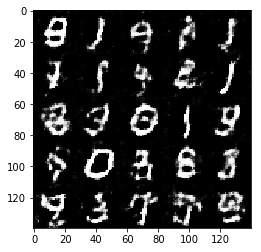

Epoch 1/2 Batch 610/1875... Discriminator Loss: 0.5562 Generator Loss: 1.5422
Epoch 1/2 Batch 620/1875... Discriminator Loss: 0.5316 Generator Loss: 1.5244
Epoch 1/2 Batch 630/1875... Discriminator Loss: 0.6140 Generator Loss: 1.1332
Epoch 1/2 Batch 640/1875... Discriminator Loss: 0.5638 Generator Loss: 2.5242
Epoch 1/2 Batch 650/1875... Discriminator Loss: 0.3907 Generator Loss: 1.8244
Epoch 1/2 Batch 660/1875... Discriminator Loss: 0.4196 Generator Loss: 2.1679
Epoch 1/2 Batch 670/1875... Discriminator Loss: 0.5079 Generator Loss: 1.8126
Epoch 1/2 Batch 680/1875... Discriminator Loss: 0.3382 Generator Loss: 1.5155
Epoch 1/2 Batch 690/1875... Discriminator Loss: 0.3921 Generator Loss: 1.7271
Epoch 1/2 Batch 700/1875... Discriminator Loss: 0.2235 Generator Loss: 2.4405


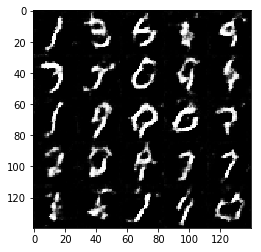

Epoch 1/2 Batch 710/1875... Discriminator Loss: 1.0713 Generator Loss: 0.9689
Epoch 1/2 Batch 720/1875... Discriminator Loss: 0.3895 Generator Loss: 2.1501
Epoch 1/2 Batch 730/1875... Discriminator Loss: 0.3624 Generator Loss: 2.0052
Epoch 1/2 Batch 740/1875... Discriminator Loss: 0.3411 Generator Loss: 2.0963
Epoch 1/2 Batch 750/1875... Discriminator Loss: 0.2625 Generator Loss: 2.9370
Epoch 1/2 Batch 760/1875... Discriminator Loss: 0.1581 Generator Loss: 2.9154
Epoch 1/2 Batch 770/1875... Discriminator Loss: 0.3085 Generator Loss: 2.5329
Epoch 1/2 Batch 780/1875... Discriminator Loss: 0.3503 Generator Loss: 2.1382
Epoch 1/2 Batch 790/1875... Discriminator Loss: 0.2276 Generator Loss: 2.8522
Epoch 1/2 Batch 800/1875... Discriminator Loss: 2.1260 Generator Loss: 0.1986


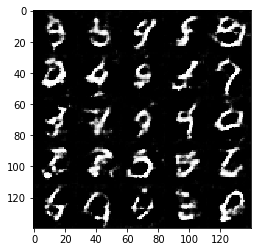

Epoch 1/2 Batch 810/1875... Discriminator Loss: 0.3989 Generator Loss: 1.7619
Epoch 1/2 Batch 820/1875... Discriminator Loss: 0.5269 Generator Loss: 1.6082
Epoch 1/2 Batch 830/1875... Discriminator Loss: 0.3724 Generator Loss: 2.3230
Epoch 1/2 Batch 840/1875... Discriminator Loss: 0.2657 Generator Loss: 3.0621
Epoch 1/2 Batch 850/1875... Discriminator Loss: 0.2933 Generator Loss: 2.0826
Epoch 1/2 Batch 860/1875... Discriminator Loss: 0.4277 Generator Loss: 1.7269
Epoch 1/2 Batch 870/1875... Discriminator Loss: 0.3453 Generator Loss: 2.2116
Epoch 1/2 Batch 880/1875... Discriminator Loss: 1.7952 Generator Loss: 0.1947
Epoch 1/2 Batch 890/1875... Discriminator Loss: 0.6934 Generator Loss: 1.1222
Epoch 1/2 Batch 900/1875... Discriminator Loss: 0.2105 Generator Loss: 2.6657


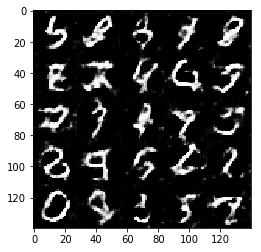

Epoch 1/2 Batch 910/1875... Discriminator Loss: 0.4869 Generator Loss: 3.5055
Epoch 1/2 Batch 920/1875... Discriminator Loss: 0.2968 Generator Loss: 2.6511
Epoch 1/2 Batch 930/1875... Discriminator Loss: 0.6028 Generator Loss: 1.4074
Epoch 1/2 Batch 940/1875... Discriminator Loss: 0.5235 Generator Loss: 0.9880
Epoch 1/2 Batch 950/1875... Discriminator Loss: 0.4598 Generator Loss: 2.9726
Epoch 1/2 Batch 960/1875... Discriminator Loss: 0.2918 Generator Loss: 2.1615
Epoch 1/2 Batch 970/1875... Discriminator Loss: 0.3637 Generator Loss: 2.3794
Epoch 1/2 Batch 980/1875... Discriminator Loss: 0.2655 Generator Loss: 1.7889
Epoch 1/2 Batch 990/1875... Discriminator Loss: 0.4821 Generator Loss: 1.4491
Epoch 1/2 Batch 1000/1875... Discriminator Loss: 0.2031 Generator Loss: 2.2377


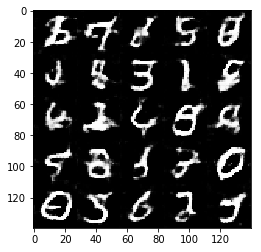

Epoch 1/2 Batch 1010/1875... Discriminator Loss: 0.6996 Generator Loss: 0.6719
Epoch 1/2 Batch 1020/1875... Discriminator Loss: 0.2716 Generator Loss: 2.7949
Epoch 1/2 Batch 1030/1875... Discriminator Loss: 0.4841 Generator Loss: 1.8092
Epoch 1/2 Batch 1040/1875... Discriminator Loss: 0.4533 Generator Loss: 1.6391
Epoch 1/2 Batch 1050/1875... Discriminator Loss: 0.1765 Generator Loss: 2.5492
Epoch 1/2 Batch 1060/1875... Discriminator Loss: 0.2476 Generator Loss: 1.9488
Epoch 1/2 Batch 1070/1875... Discriminator Loss: 0.2349 Generator Loss: 2.6002
Epoch 1/2 Batch 1080/1875... Discriminator Loss: 0.3942 Generator Loss: 2.5795
Epoch 1/2 Batch 1090/1875... Discriminator Loss: 0.3681 Generator Loss: 4.1268
Epoch 1/2 Batch 1100/1875... Discriminator Loss: 0.4229 Generator Loss: 1.8993


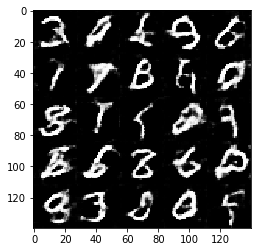

Epoch 1/2 Batch 1110/1875... Discriminator Loss: 0.4069 Generator Loss: 1.8880
Epoch 1/2 Batch 1120/1875... Discriminator Loss: 0.3986 Generator Loss: 2.5642
Epoch 1/2 Batch 1130/1875... Discriminator Loss: 0.2209 Generator Loss: 2.4429
Epoch 1/2 Batch 1140/1875... Discriminator Loss: 1.0500 Generator Loss: 0.5988
Epoch 1/2 Batch 1150/1875... Discriminator Loss: 0.3268 Generator Loss: 2.2977
Epoch 1/2 Batch 1160/1875... Discriminator Loss: 0.3343 Generator Loss: 4.3030
Epoch 1/2 Batch 1170/1875... Discriminator Loss: 0.9461 Generator Loss: 4.6752
Epoch 1/2 Batch 1180/1875... Discriminator Loss: 0.3079 Generator Loss: 1.9778
Epoch 1/2 Batch 1190/1875... Discriminator Loss: 0.2007 Generator Loss: 2.6813
Epoch 1/2 Batch 1200/1875... Discriminator Loss: 0.3800 Generator Loss: 1.7136


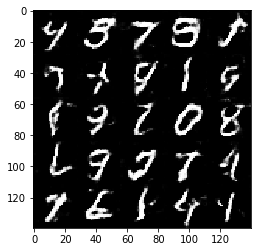

Epoch 1/2 Batch 1210/1875... Discriminator Loss: 0.1954 Generator Loss: 2.8058
Epoch 1/2 Batch 1220/1875... Discriminator Loss: 0.4672 Generator Loss: 2.1503
Epoch 1/2 Batch 1230/1875... Discriminator Loss: 0.3534 Generator Loss: 2.1931
Epoch 1/2 Batch 1240/1875... Discriminator Loss: 0.2197 Generator Loss: 2.4056
Epoch 1/2 Batch 1250/1875... Discriminator Loss: 0.1846 Generator Loss: 2.9796
Epoch 1/2 Batch 1260/1875... Discriminator Loss: 0.3490 Generator Loss: 2.0574
Epoch 1/2 Batch 1270/1875... Discriminator Loss: 0.4122 Generator Loss: 2.1265
Epoch 1/2 Batch 1280/1875... Discriminator Loss: 0.1473 Generator Loss: 2.8265
Epoch 1/2 Batch 1290/1875... Discriminator Loss: 0.3304 Generator Loss: 1.8030
Epoch 1/2 Batch 1300/1875... Discriminator Loss: 0.2037 Generator Loss: 2.3080


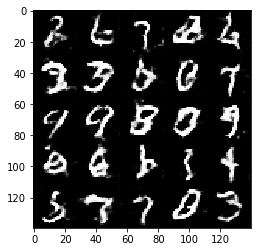

Epoch 1/2 Batch 1310/1875... Discriminator Loss: 0.4379 Generator Loss: 3.3719
Epoch 1/2 Batch 1320/1875... Discriminator Loss: 0.1846 Generator Loss: 2.2049
Epoch 1/2 Batch 1330/1875... Discriminator Loss: 0.1936 Generator Loss: 1.9967
Epoch 1/2 Batch 1340/1875... Discriminator Loss: 0.1576 Generator Loss: 2.7311
Epoch 1/2 Batch 1350/1875... Discriminator Loss: 0.7768 Generator Loss: 5.1067
Epoch 1/2 Batch 1360/1875... Discriminator Loss: 1.4896 Generator Loss: 0.6314
Epoch 1/2 Batch 1370/1875... Discriminator Loss: 0.1353 Generator Loss: 2.3153
Epoch 1/2 Batch 1380/1875... Discriminator Loss: 0.1851 Generator Loss: 3.5220
Epoch 1/2 Batch 1390/1875... Discriminator Loss: 0.1930 Generator Loss: 2.4231
Epoch 1/2 Batch 1400/1875... Discriminator Loss: 0.5120 Generator Loss: 1.3074


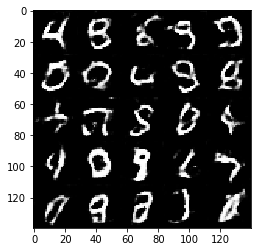

Epoch 1/2 Batch 1410/1875... Discriminator Loss: 0.1629 Generator Loss: 3.6549
Epoch 1/2 Batch 1420/1875... Discriminator Loss: 0.1470 Generator Loss: 2.3490
Epoch 1/2 Batch 1430/1875... Discriminator Loss: 2.0871 Generator Loss: 7.5940
Epoch 1/2 Batch 1440/1875... Discriminator Loss: 0.3739 Generator Loss: 1.6366
Epoch 1/2 Batch 1450/1875... Discriminator Loss: 0.2381 Generator Loss: 2.7087
Epoch 1/2 Batch 1460/1875... Discriminator Loss: 0.2812 Generator Loss: 2.1167
Epoch 1/2 Batch 1470/1875... Discriminator Loss: 0.1435 Generator Loss: 2.3767
Epoch 1/2 Batch 1480/1875... Discriminator Loss: 0.1002 Generator Loss: 3.9818
Epoch 1/2 Batch 1490/1875... Discriminator Loss: 0.2653 Generator Loss: 2.8246
Epoch 1/2 Batch 1500/1875... Discriminator Loss: 0.1046 Generator Loss: 3.1610


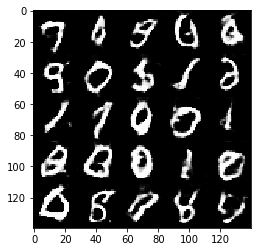

Epoch 1/2 Batch 1510/1875... Discriminator Loss: 0.6141 Generator Loss: 0.9860
Epoch 1/2 Batch 1520/1875... Discriminator Loss: 0.0692 Generator Loss: 3.6722
Epoch 1/2 Batch 1530/1875... Discriminator Loss: 0.1209 Generator Loss: 3.6140
Epoch 1/2 Batch 1540/1875... Discriminator Loss: 0.1064 Generator Loss: 2.9398
Epoch 1/2 Batch 1550/1875... Discriminator Loss: 0.1001 Generator Loss: 3.9297
Epoch 1/2 Batch 1560/1875... Discriminator Loss: 0.1189 Generator Loss: 2.7934
Epoch 1/2 Batch 1570/1875... Discriminator Loss: 0.2232 Generator Loss: 1.9902
Epoch 1/2 Batch 1580/1875... Discriminator Loss: 0.0991 Generator Loss: 3.0443
Epoch 1/2 Batch 1590/1875... Discriminator Loss: 0.0458 Generator Loss: 3.8023
Epoch 1/2 Batch 1600/1875... Discriminator Loss: 0.0642 Generator Loss: 3.3958


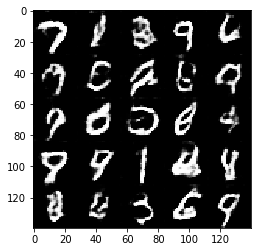

Epoch 1/2 Batch 1610/1875... Discriminator Loss: 0.6678 Generator Loss: 1.9746
Epoch 1/2 Batch 1620/1875... Discriminator Loss: 0.1371 Generator Loss: 3.9415
Epoch 1/2 Batch 1630/1875... Discriminator Loss: 0.1447 Generator Loss: 2.8416
Epoch 1/2 Batch 1640/1875... Discriminator Loss: 0.0996 Generator Loss: 3.8205
Epoch 1/2 Batch 1650/1875... Discriminator Loss: 0.0574 Generator Loss: 4.8566
Epoch 1/2 Batch 1660/1875... Discriminator Loss: 0.0478 Generator Loss: 4.8487
Epoch 1/2 Batch 1670/1875... Discriminator Loss: 0.2575 Generator Loss: 3.0374
Epoch 1/2 Batch 1680/1875... Discriminator Loss: 0.0348 Generator Loss: 4.1123
Epoch 1/2 Batch 1690/1875... Discriminator Loss: 0.4970 Generator Loss: 1.6631
Epoch 1/2 Batch 1700/1875... Discriminator Loss: 0.7053 Generator Loss: 1.6794


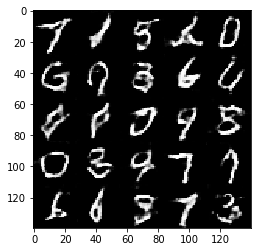

Epoch 1/2 Batch 1710/1875... Discriminator Loss: 0.3953 Generator Loss: 2.6471
Epoch 1/2 Batch 1720/1875... Discriminator Loss: 0.7843 Generator Loss: 1.5489
Epoch 1/2 Batch 1730/1875... Discriminator Loss: 0.3774 Generator Loss: 1.5185
Epoch 1/2 Batch 1740/1875... Discriminator Loss: 0.2979 Generator Loss: 2.0393
Epoch 1/2 Batch 1750/1875... Discriminator Loss: 0.2439 Generator Loss: 2.9299
Epoch 1/2 Batch 1760/1875... Discriminator Loss: 0.2114 Generator Loss: 2.3153
Epoch 1/2 Batch 1770/1875... Discriminator Loss: 0.2510 Generator Loss: 3.5232
Epoch 1/2 Batch 1780/1875... Discriminator Loss: 0.1556 Generator Loss: 1.8624
Epoch 1/2 Batch 1790/1875... Discriminator Loss: 0.1118 Generator Loss: 2.9009
Epoch 1/2 Batch 1800/1875... Discriminator Loss: 0.1055 Generator Loss: 3.0721


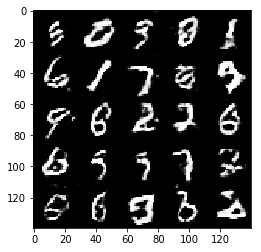

Epoch 1/2 Batch 1810/1875... Discriminator Loss: 0.1716 Generator Loss: 3.3568
Epoch 1/2 Batch 1820/1875... Discriminator Loss: 0.1580 Generator Loss: 2.5681
Epoch 1/2 Batch 1830/1875... Discriminator Loss: 0.2350 Generator Loss: 2.2820
Epoch 1/2 Batch 1840/1875... Discriminator Loss: 0.1435 Generator Loss: 2.7751
Epoch 1/2 Batch 1850/1875... Discriminator Loss: 0.1752 Generator Loss: 2.4646
Epoch 1/2 Batch 1860/1875... Discriminator Loss: 0.1618 Generator Loss: 3.7061
Epoch 1/2 Batch 1870/1875... Discriminator Loss: 0.0482 Generator Loss: 4.0180
Epoch 2/2 Batch 5/1875... Discriminator Loss: 0.1436 Generator Loss: 2.8462
Epoch 2/2 Batch 15/1875... Discriminator Loss: 0.4813 Generator Loss: 2.2233
Epoch 2/2 Batch 25/1875... Discriminator Loss: 0.3273 Generator Loss: 3.7743


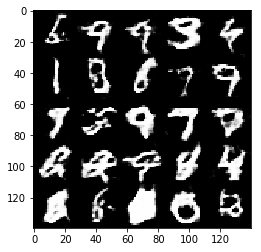

Epoch 2/2 Batch 35/1875... Discriminator Loss: 0.5693 Generator Loss: 2.1288
Epoch 2/2 Batch 45/1875... Discriminator Loss: 0.3471 Generator Loss: 2.1603
Epoch 2/2 Batch 55/1875... Discriminator Loss: 0.4378 Generator Loss: 1.9867
Epoch 2/2 Batch 65/1875... Discriminator Loss: 0.1603 Generator Loss: 2.6616
Epoch 2/2 Batch 75/1875... Discriminator Loss: 0.1338 Generator Loss: 3.0667
Epoch 2/2 Batch 85/1875... Discriminator Loss: 0.1387 Generator Loss: 4.2838
Epoch 2/2 Batch 95/1875... Discriminator Loss: 0.1895 Generator Loss: 2.1150
Epoch 2/2 Batch 105/1875... Discriminator Loss: 0.1464 Generator Loss: 2.6533
Epoch 2/2 Batch 115/1875... Discriminator Loss: 0.1225 Generator Loss: 3.5357
Epoch 2/2 Batch 125/1875... Discriminator Loss: 0.0610 Generator Loss: 4.6555


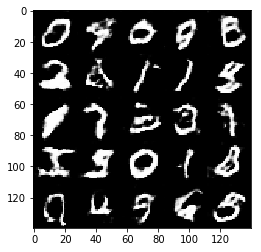

Epoch 2/2 Batch 135/1875... Discriminator Loss: 0.0896 Generator Loss: 4.0623
Epoch 2/2 Batch 145/1875... Discriminator Loss: 0.0596 Generator Loss: 3.5914
Epoch 2/2 Batch 155/1875... Discriminator Loss: 0.0836 Generator Loss: 3.5445
Epoch 2/2 Batch 165/1875... Discriminator Loss: 0.1179 Generator Loss: 3.3563
Epoch 2/2 Batch 175/1875... Discriminator Loss: 0.0881 Generator Loss: 3.4918
Epoch 2/2 Batch 185/1875... Discriminator Loss: 0.0333 Generator Loss: 4.2686
Epoch 2/2 Batch 195/1875... Discriminator Loss: 0.0624 Generator Loss: 3.8948
Epoch 2/2 Batch 205/1875... Discriminator Loss: 0.1415 Generator Loss: 3.0246
Epoch 2/2 Batch 215/1875... Discriminator Loss: 0.2753 Generator Loss: 2.4484
Epoch 2/2 Batch 225/1875... Discriminator Loss: 0.3403 Generator Loss: 1.6730


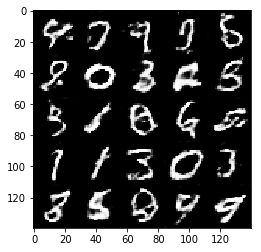

Epoch 2/2 Batch 235/1875... Discriminator Loss: 0.5917 Generator Loss: 3.6720
Epoch 2/2 Batch 245/1875... Discriminator Loss: 0.5062 Generator Loss: 2.4136
Epoch 2/2 Batch 255/1875... Discriminator Loss: 0.3205 Generator Loss: 1.9974
Epoch 2/2 Batch 265/1875... Discriminator Loss: 0.3827 Generator Loss: 2.7011
Epoch 2/2 Batch 275/1875... Discriminator Loss: 0.2630 Generator Loss: 2.0858
Epoch 2/2 Batch 285/1875... Discriminator Loss: 0.3331 Generator Loss: 2.7512
Epoch 2/2 Batch 295/1875... Discriminator Loss: 0.3140 Generator Loss: 1.6357
Epoch 2/2 Batch 305/1875... Discriminator Loss: 0.2210 Generator Loss: 3.1528
Epoch 2/2 Batch 315/1875... Discriminator Loss: 0.0831 Generator Loss: 3.4710
Epoch 2/2 Batch 325/1875... Discriminator Loss: 0.1916 Generator Loss: 2.9056


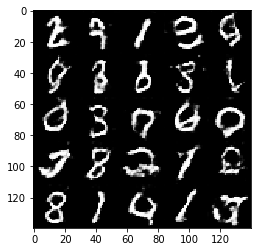

Epoch 2/2 Batch 335/1875... Discriminator Loss: 0.1669 Generator Loss: 3.8528
Epoch 2/2 Batch 345/1875... Discriminator Loss: 0.2498 Generator Loss: 2.2028
Epoch 2/2 Batch 355/1875... Discriminator Loss: 0.0748 Generator Loss: 3.8579
Epoch 2/2 Batch 365/1875... Discriminator Loss: 0.0570 Generator Loss: 3.2876
Epoch 2/2 Batch 375/1875... Discriminator Loss: 0.0687 Generator Loss: 3.5295
Epoch 2/2 Batch 385/1875... Discriminator Loss: 0.0498 Generator Loss: 3.5748
Epoch 2/2 Batch 395/1875... Discriminator Loss: 0.1627 Generator Loss: 3.8924
Epoch 2/2 Batch 405/1875... Discriminator Loss: 0.0750 Generator Loss: 3.8871
Epoch 2/2 Batch 415/1875... Discriminator Loss: 0.1167 Generator Loss: 3.9307
Epoch 2/2 Batch 425/1875... Discriminator Loss: 0.1480 Generator Loss: 3.1365


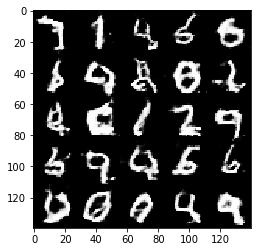

Epoch 2/2 Batch 435/1875... Discriminator Loss: 0.2089 Generator Loss: 4.0736
Epoch 2/2 Batch 445/1875... Discriminator Loss: 0.1576 Generator Loss: 3.2953
Epoch 2/2 Batch 455/1875... Discriminator Loss: 0.0928 Generator Loss: 3.5573
Epoch 2/2 Batch 465/1875... Discriminator Loss: 0.2138 Generator Loss: 3.0962
Epoch 2/2 Batch 475/1875... Discriminator Loss: 0.0282 Generator Loss: 5.2038
Epoch 2/2 Batch 485/1875... Discriminator Loss: 0.0351 Generator Loss: 4.3219
Epoch 2/2 Batch 495/1875... Discriminator Loss: 0.0767 Generator Loss: 3.1706
Epoch 2/2 Batch 505/1875... Discriminator Loss: 0.1002 Generator Loss: 2.7532
Epoch 2/2 Batch 515/1875... Discriminator Loss: 0.0610 Generator Loss: 4.6199
Epoch 2/2 Batch 525/1875... Discriminator Loss: 0.0451 Generator Loss: 4.3510


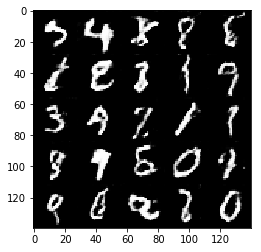

Epoch 2/2 Batch 535/1875... Discriminator Loss: 0.3657 Generator Loss: 2.9837
Epoch 2/2 Batch 545/1875... Discriminator Loss: 0.2719 Generator Loss: 2.3256
Epoch 2/2 Batch 555/1875... Discriminator Loss: 0.1215 Generator Loss: 3.0096
Epoch 2/2 Batch 565/1875... Discriminator Loss: 0.2100 Generator Loss: 2.0799
Epoch 2/2 Batch 575/1875... Discriminator Loss: 0.1286 Generator Loss: 3.7897
Epoch 2/2 Batch 585/1875... Discriminator Loss: 0.5521 Generator Loss: 1.5054
Epoch 2/2 Batch 595/1875... Discriminator Loss: 0.4270 Generator Loss: 1.0835
Epoch 2/2 Batch 605/1875... Discriminator Loss: 0.1199 Generator Loss: 3.0848
Epoch 2/2 Batch 615/1875... Discriminator Loss: 0.0766 Generator Loss: 4.8265
Epoch 2/2 Batch 625/1875... Discriminator Loss: 0.0678 Generator Loss: 4.2460


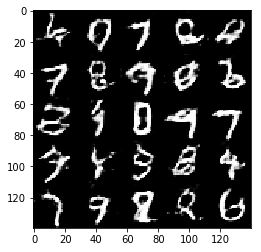

Epoch 2/2 Batch 635/1875... Discriminator Loss: 0.0860 Generator Loss: 4.0409
Epoch 2/2 Batch 645/1875... Discriminator Loss: 0.1033 Generator Loss: 5.1629
Epoch 2/2 Batch 655/1875... Discriminator Loss: 0.0359 Generator Loss: 4.4321
Epoch 2/2 Batch 665/1875... Discriminator Loss: 0.1537 Generator Loss: 3.7512
Epoch 2/2 Batch 675/1875... Discriminator Loss: 0.0889 Generator Loss: 2.6651
Epoch 2/2 Batch 685/1875... Discriminator Loss: 0.1674 Generator Loss: 2.1217
Epoch 2/2 Batch 695/1875... Discriminator Loss: 0.0331 Generator Loss: 5.9283
Epoch 2/2 Batch 705/1875... Discriminator Loss: 0.0621 Generator Loss: 6.0943
Epoch 2/2 Batch 715/1875... Discriminator Loss: 0.0239 Generator Loss: 4.3654
Epoch 2/2 Batch 725/1875... Discriminator Loss: 0.0883 Generator Loss: 3.6818


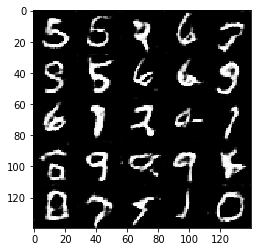

Epoch 2/2 Batch 735/1875... Discriminator Loss: 0.0271 Generator Loss: 3.6708
Epoch 2/2 Batch 745/1875... Discriminator Loss: 0.0364 Generator Loss: 3.7279
Epoch 2/2 Batch 755/1875... Discriminator Loss: 0.0272 Generator Loss: 4.7610
Epoch 2/2 Batch 765/1875... Discriminator Loss: 1.1311 Generator Loss: 0.7317
Epoch 2/2 Batch 775/1875... Discriminator Loss: 0.5146 Generator Loss: 4.3494
Epoch 2/2 Batch 785/1875... Discriminator Loss: 0.5223 Generator Loss: 1.7943
Epoch 2/2 Batch 795/1875... Discriminator Loss: 0.2537 Generator Loss: 2.7475
Epoch 2/2 Batch 805/1875... Discriminator Loss: 0.0846 Generator Loss: 3.6413
Epoch 2/2 Batch 815/1875... Discriminator Loss: 0.0602 Generator Loss: 3.4458
Epoch 2/2 Batch 825/1875... Discriminator Loss: 0.1898 Generator Loss: 3.3322


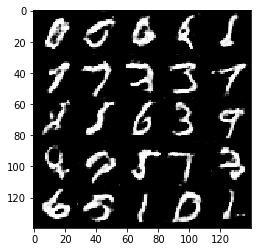

Epoch 2/2 Batch 835/1875... Discriminator Loss: 0.1010 Generator Loss: 4.2749
Epoch 2/2 Batch 845/1875... Discriminator Loss: 0.1205 Generator Loss: 4.1983
Epoch 2/2 Batch 855/1875... Discriminator Loss: 0.1160 Generator Loss: 3.6853
Epoch 2/2 Batch 865/1875... Discriminator Loss: 0.0407 Generator Loss: 4.6033
Epoch 2/2 Batch 875/1875... Discriminator Loss: 0.0247 Generator Loss: 4.6724
Epoch 2/2 Batch 885/1875... Discriminator Loss: 0.0435 Generator Loss: 5.2064
Epoch 2/2 Batch 895/1875... Discriminator Loss: 0.0454 Generator Loss: 4.3016
Epoch 2/2 Batch 905/1875... Discriminator Loss: 0.0160 Generator Loss: 4.2882
Epoch 2/2 Batch 915/1875... Discriminator Loss: 0.0746 Generator Loss: 3.0916
Epoch 2/2 Batch 925/1875... Discriminator Loss: 0.0746 Generator Loss: 4.7129


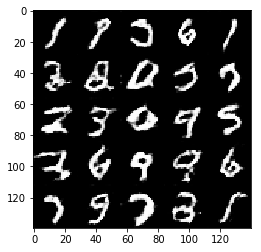

Epoch 2/2 Batch 935/1875... Discriminator Loss: 0.1813 Generator Loss: 3.0191
Epoch 2/2 Batch 945/1875... Discriminator Loss: 0.1294 Generator Loss: 3.2112
Epoch 2/2 Batch 955/1875... Discriminator Loss: 0.0753 Generator Loss: 3.4159
Epoch 2/2 Batch 965/1875... Discriminator Loss: 0.1296 Generator Loss: 2.3718
Epoch 2/2 Batch 975/1875... Discriminator Loss: 0.0711 Generator Loss: 2.7367
Epoch 2/2 Batch 985/1875... Discriminator Loss: 0.0791 Generator Loss: 3.9194
Epoch 2/2 Batch 995/1875... Discriminator Loss: 0.1058 Generator Loss: 3.4728
Epoch 2/2 Batch 1005/1875... Discriminator Loss: 0.0578 Generator Loss: 4.6740
Epoch 2/2 Batch 1015/1875... Discriminator Loss: 0.0533 Generator Loss: 4.5689
Epoch 2/2 Batch 1025/1875... Discriminator Loss: 0.0729 Generator Loss: 3.3454


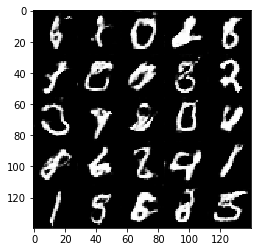

Epoch 2/2 Batch 1035/1875... Discriminator Loss: 0.0527 Generator Loss: 3.6311
Epoch 2/2 Batch 1045/1875... Discriminator Loss: 0.0305 Generator Loss: 4.6341
Epoch 2/2 Batch 1055/1875... Discriminator Loss: 0.0306 Generator Loss: 4.1304
Epoch 2/2 Batch 1065/1875... Discriminator Loss: 0.0436 Generator Loss: 4.1959
Epoch 2/2 Batch 1075/1875... Discriminator Loss: 0.0561 Generator Loss: 4.0283
Epoch 2/2 Batch 1085/1875... Discriminator Loss: 0.0259 Generator Loss: 4.5928
Epoch 2/2 Batch 1095/1875... Discriminator Loss: 0.1207 Generator Loss: 4.1100
Epoch 2/2 Batch 1105/1875... Discriminator Loss: 0.0605 Generator Loss: 3.9877
Epoch 2/2 Batch 1115/1875... Discriminator Loss: 0.0337 Generator Loss: 4.8192
Epoch 2/2 Batch 1125/1875... Discriminator Loss: 0.0178 Generator Loss: 5.1861


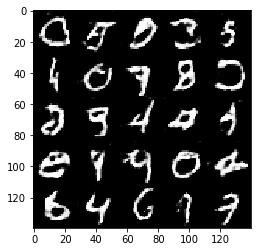

Epoch 2/2 Batch 1135/1875... Discriminator Loss: 0.0379 Generator Loss: 4.1478
Epoch 2/2 Batch 1145/1875... Discriminator Loss: 0.0594 Generator Loss: 4.3650
Epoch 2/2 Batch 1155/1875... Discriminator Loss: 0.0647 Generator Loss: 4.6604
Epoch 2/2 Batch 1165/1875... Discriminator Loss: 0.0501 Generator Loss: 5.8911
Epoch 2/2 Batch 1175/1875... Discriminator Loss: 0.0171 Generator Loss: 6.5903
Epoch 2/2 Batch 1185/1875... Discriminator Loss: 0.0202 Generator Loss: 5.2187
Epoch 2/2 Batch 1195/1875... Discriminator Loss: 0.0108 Generator Loss: 5.4852
Epoch 2/2 Batch 1205/1875... Discriminator Loss: 0.0143 Generator Loss: 6.5347
Epoch 2/2 Batch 1215/1875... Discriminator Loss: 0.0857 Generator Loss: 4.4917
Epoch 2/2 Batch 1225/1875... Discriminator Loss: 0.0136 Generator Loss: 5.3267


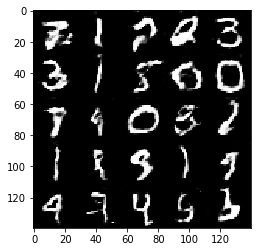

Epoch 2/2 Batch 1235/1875... Discriminator Loss: 0.0145 Generator Loss: 4.8489
Epoch 2/2 Batch 1245/1875... Discriminator Loss: 0.0979 Generator Loss: 7.6917
Epoch 2/2 Batch 1255/1875... Discriminator Loss: 0.0270 Generator Loss: 5.2838
Epoch 2/2 Batch 1265/1875... Discriminator Loss: 0.0170 Generator Loss: 4.2689
Epoch 2/2 Batch 1275/1875... Discriminator Loss: 0.0254 Generator Loss: 5.4843
Epoch 2/2 Batch 1285/1875... Discriminator Loss: 0.0268 Generator Loss: 5.7431
Epoch 2/2 Batch 1295/1875... Discriminator Loss: 0.1275 Generator Loss: 2.8687
Epoch 2/2 Batch 1305/1875... Discriminator Loss: 1.4283 Generator Loss: 7.4613
Epoch 2/2 Batch 1315/1875... Discriminator Loss: 0.3072 Generator Loss: 1.6577
Epoch 2/2 Batch 1325/1875... Discriminator Loss: 0.3936 Generator Loss: 4.3415


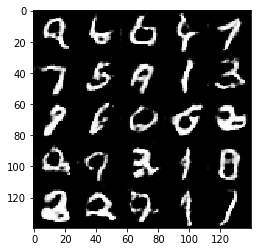

Epoch 2/2 Batch 1335/1875... Discriminator Loss: 0.1932 Generator Loss: 3.6775
Epoch 2/2 Batch 1345/1875... Discriminator Loss: 0.1305 Generator Loss: 2.8476
Epoch 2/2 Batch 1355/1875... Discriminator Loss: 0.1317 Generator Loss: 3.2287
Epoch 2/2 Batch 1365/1875... Discriminator Loss: 0.1325 Generator Loss: 2.7859
Epoch 2/2 Batch 1375/1875... Discriminator Loss: 0.0343 Generator Loss: 3.7828
Epoch 2/2 Batch 1385/1875... Discriminator Loss: 0.0423 Generator Loss: 4.7693
Epoch 2/2 Batch 1395/1875... Discriminator Loss: 0.0709 Generator Loss: 4.5809
Epoch 2/2 Batch 1405/1875... Discriminator Loss: 0.0724 Generator Loss: 4.1352
Epoch 2/2 Batch 1415/1875... Discriminator Loss: 0.0744 Generator Loss: 4.0995
Epoch 2/2 Batch 1425/1875... Discriminator Loss: 0.0338 Generator Loss: 4.3027


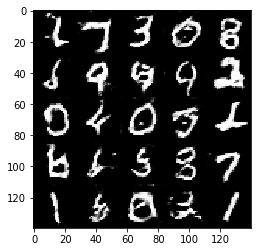

Epoch 2/2 Batch 1435/1875... Discriminator Loss: 0.0188 Generator Loss: 4.9602
Epoch 2/2 Batch 1445/1875... Discriminator Loss: 0.0164 Generator Loss: 4.8473
Epoch 2/2 Batch 1455/1875... Discriminator Loss: 0.0440 Generator Loss: 3.7146
Epoch 2/2 Batch 1465/1875... Discriminator Loss: 0.0277 Generator Loss: 3.5480
Epoch 2/2 Batch 1475/1875... Discriminator Loss: 0.1177 Generator Loss: 3.2326
Epoch 2/2 Batch 1485/1875... Discriminator Loss: 0.0158 Generator Loss: 6.5353
Epoch 2/2 Batch 1495/1875... Discriminator Loss: 0.0247 Generator Loss: 4.2526
Epoch 2/2 Batch 1505/1875... Discriminator Loss: 0.0152 Generator Loss: 5.8811
Epoch 2/2 Batch 1515/1875... Discriminator Loss: 0.0210 Generator Loss: 4.7924
Epoch 2/2 Batch 1525/1875... Discriminator Loss: 0.1493 Generator Loss: 3.2004


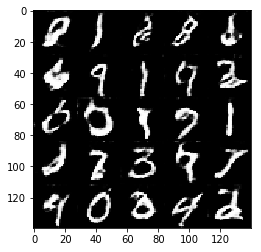

Epoch 2/2 Batch 1535/1875... Discriminator Loss: 0.0165 Generator Loss: 5.2001
Epoch 2/2 Batch 1545/1875... Discriminator Loss: 0.0815 Generator Loss: 4.6097
Epoch 2/2 Batch 1555/1875... Discriminator Loss: 0.0336 Generator Loss: 5.0858
Epoch 2/2 Batch 1565/1875... Discriminator Loss: 0.0680 Generator Loss: 4.7400
Epoch 2/2 Batch 1575/1875... Discriminator Loss: 0.0529 Generator Loss: 3.9033
Epoch 2/2 Batch 1585/1875... Discriminator Loss: 0.0391 Generator Loss: 5.8385
Epoch 2/2 Batch 1595/1875... Discriminator Loss: 0.0260 Generator Loss: 4.6830
Epoch 2/2 Batch 1605/1875... Discriminator Loss: 0.0125 Generator Loss: 4.7161
Epoch 2/2 Batch 1615/1875... Discriminator Loss: 0.0834 Generator Loss: 6.7781
Epoch 2/2 Batch 1625/1875... Discriminator Loss: 0.0306 Generator Loss: 5.7499


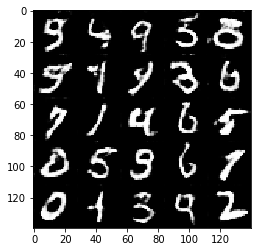

Epoch 2/2 Batch 1635/1875... Discriminator Loss: 0.0577 Generator Loss: 3.7123
Epoch 2/2 Batch 1645/1875... Discriminator Loss: 0.0210 Generator Loss: 5.1259
Epoch 2/2 Batch 1655/1875... Discriminator Loss: 0.0144 Generator Loss: 5.5329
Epoch 2/2 Batch 1665/1875... Discriminator Loss: 0.0149 Generator Loss: 4.4332
Epoch 2/2 Batch 1675/1875... Discriminator Loss: 0.0084 Generator Loss: 5.1154
Epoch 2/2 Batch 1685/1875... Discriminator Loss: 0.0088 Generator Loss: 7.3791
Epoch 2/2 Batch 1695/1875... Discriminator Loss: 0.8099 Generator Loss: 1.4496
Epoch 2/2 Batch 1705/1875... Discriminator Loss: 0.0701 Generator Loss: 4.5202
Epoch 2/2 Batch 1715/1875... Discriminator Loss: 1.7920 Generator Loss: 0.6630
Epoch 2/2 Batch 1725/1875... Discriminator Loss: 0.3368 Generator Loss: 2.3823


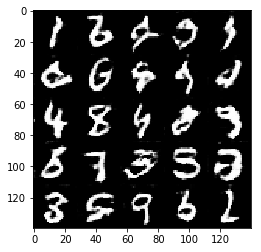

Epoch 2/2 Batch 1735/1875... Discriminator Loss: 0.2767 Generator Loss: 1.8352
Epoch 2/2 Batch 1745/1875... Discriminator Loss: 0.3226 Generator Loss: 2.2278
Epoch 2/2 Batch 1755/1875... Discriminator Loss: 0.0838 Generator Loss: 2.4379
Epoch 2/2 Batch 1765/1875... Discriminator Loss: 0.1861 Generator Loss: 3.5245
Epoch 2/2 Batch 1775/1875... Discriminator Loss: 0.0474 Generator Loss: 5.5768
Epoch 2/2 Batch 1785/1875... Discriminator Loss: 0.0610 Generator Loss: 4.5610
Epoch 2/2 Batch 1795/1875... Discriminator Loss: 0.0594 Generator Loss: 3.3068
Epoch 2/2 Batch 1805/1875... Discriminator Loss: 0.1233 Generator Loss: 3.1626
Epoch 2/2 Batch 1815/1875... Discriminator Loss: 0.0650 Generator Loss: 4.2774
Epoch 2/2 Batch 1825/1875... Discriminator Loss: 0.1046 Generator Loss: 3.0042


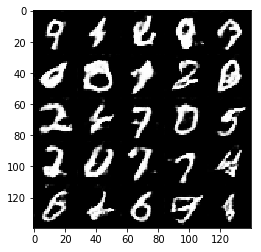

Epoch 2/2 Batch 1835/1875... Discriminator Loss: 0.0398 Generator Loss: 4.4953
Epoch 2/2 Batch 1845/1875... Discriminator Loss: 0.0305 Generator Loss: 4.1698
Epoch 2/2 Batch 1855/1875... Discriminator Loss: 0.0451 Generator Loss: 4.0889
Epoch 2/2 Batch 1865/1875... Discriminator Loss: 0.0383 Generator Loss: 5.2671
Epoch 2/2 Batch 1875/1875... Discriminator Loss: 0.0222 Generator Loss: 5.5503
Finished!


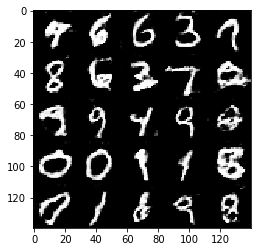

In [13]:
batch_size = 32
z_dim = 128
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Batch 10/6331... Discriminator Loss: 0.0804 Generator Loss: 3.0311
Epoch 1/1 Batch 20/6331... Discriminator Loss: 0.1239 Generator Loss: 2.4237
Epoch 1/1 Batch 30/6331... Discriminator Loss: 1.3254 Generator Loss: 0.4971
Epoch 1/1 Batch 40/6331... Discriminator Loss: 0.2708 Generator Loss: 2.1432
Epoch 1/1 Batch 50/6331... Discriminator Loss: 0.1846 Generator Loss: 9.1633
Epoch 1/1 Batch 60/6331... Discriminator Loss: 0.6796 Generator Loss: 14.0772
Epoch 1/1 Batch 70/6331... Discriminator Loss: 0.6042 Generator Loss: 12.0194
Epoch 1/1 Batch 80/6331... Discriminator Loss: 0.2354 Generator Loss: 8.2729
Epoch 1/1 Batch 90/6331... Discriminator Loss: 0.2632 Generator Loss: 2.9714
Epoch 1/1 Batch 100/6331... Discriminator Loss: 0.1466 Generator Loss: 3.0830


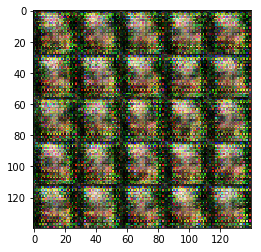

Epoch 1/1 Batch 110/6331... Discriminator Loss: 0.1188 Generator Loss: 3.3326
Epoch 1/1 Batch 120/6331... Discriminator Loss: 0.0238 Generator Loss: 4.7415
Epoch 1/1 Batch 130/6331... Discriminator Loss: 0.0542 Generator Loss: 4.0597
Epoch 1/1 Batch 140/6331... Discriminator Loss: 0.0348 Generator Loss: 4.0040
Epoch 1/1 Batch 150/6331... Discriminator Loss: 0.0442 Generator Loss: 3.8098
Epoch 1/1 Batch 160/6331... Discriminator Loss: 0.0206 Generator Loss: 5.1212
Epoch 1/1 Batch 170/6331... Discriminator Loss: 0.2986 Generator Loss: 1.4156
Epoch 1/1 Batch 180/6331... Discriminator Loss: 0.1737 Generator Loss: 9.0609
Epoch 1/1 Batch 190/6331... Discriminator Loss: 0.2017 Generator Loss: 2.2036
Epoch 1/1 Batch 200/6331... Discriminator Loss: 0.0435 Generator Loss: 4.8397


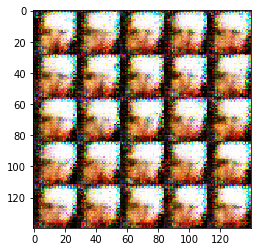

Epoch 1/1 Batch 210/6331... Discriminator Loss: 0.0293 Generator Loss: 4.1372
Epoch 1/1 Batch 220/6331... Discriminator Loss: 0.0300 Generator Loss: 4.2275
Epoch 1/1 Batch 230/6331... Discriminator Loss: 0.0684 Generator Loss: 3.2106
Epoch 1/1 Batch 240/6331... Discriminator Loss: 0.0225 Generator Loss: 13.9093
Epoch 1/1 Batch 250/6331... Discriminator Loss: 0.0242 Generator Loss: 6.7612
Epoch 1/1 Batch 260/6331... Discriminator Loss: 0.0158 Generator Loss: 4.9736
Epoch 1/1 Batch 270/6331... Discriminator Loss: 0.0200 Generator Loss: 4.5916
Epoch 1/1 Batch 280/6331... Discriminator Loss: 0.0214 Generator Loss: 4.6879
Epoch 1/1 Batch 290/6331... Discriminator Loss: 0.1152 Generator Loss: 2.5023
Epoch 1/1 Batch 300/6331... Discriminator Loss: 0.0192 Generator Loss: 4.2430


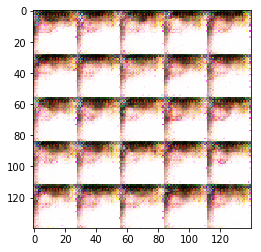

Epoch 1/1 Batch 310/6331... Discriminator Loss: 0.0279 Generator Loss: 4.4374
Epoch 1/1 Batch 320/6331... Discriminator Loss: 0.0126 Generator Loss: 6.3556
Epoch 1/1 Batch 330/6331... Discriminator Loss: 0.0281 Generator Loss: 4.9204
Epoch 1/1 Batch 340/6331... Discriminator Loss: 0.0137 Generator Loss: 5.0270
Epoch 1/1 Batch 350/6331... Discriminator Loss: 0.0279 Generator Loss: 5.6619
Epoch 1/1 Batch 360/6331... Discriminator Loss: 0.3245 Generator Loss: 16.0953
Epoch 1/1 Batch 370/6331... Discriminator Loss: 0.1338 Generator Loss: 6.9757
Epoch 1/1 Batch 380/6331... Discriminator Loss: 0.0617 Generator Loss: 4.1965
Epoch 1/1 Batch 390/6331... Discriminator Loss: 0.0440 Generator Loss: 5.0181
Epoch 1/1 Batch 400/6331... Discriminator Loss: 0.1216 Generator Loss: 2.7476


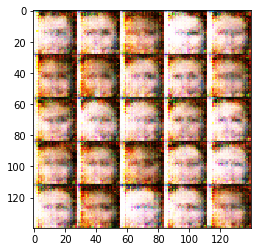

Epoch 1/1 Batch 410/6331... Discriminator Loss: 0.1002 Generator Loss: 3.8958
Epoch 1/1 Batch 420/6331... Discriminator Loss: 0.0631 Generator Loss: 3.8393
Epoch 1/1 Batch 430/6331... Discriminator Loss: 0.1895 Generator Loss: 2.3066
Epoch 1/1 Batch 440/6331... Discriminator Loss: 0.0331 Generator Loss: 5.8689
Epoch 1/1 Batch 450/6331... Discriminator Loss: 0.0740 Generator Loss: 4.0953
Epoch 1/1 Batch 460/6331... Discriminator Loss: 0.2316 Generator Loss: 2.7319
Epoch 1/1 Batch 470/6331... Discriminator Loss: 0.5786 Generator Loss: 2.2058
Epoch 1/1 Batch 480/6331... Discriminator Loss: 0.9020 Generator Loss: 0.9504
Epoch 1/1 Batch 490/6331... Discriminator Loss: 0.2810 Generator Loss: 3.4197
Epoch 1/1 Batch 500/6331... Discriminator Loss: 0.3529 Generator Loss: 2.6424


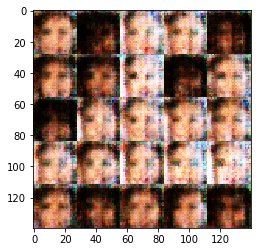

Epoch 1/1 Batch 510/6331... Discriminator Loss: 0.3342 Generator Loss: 1.7546
Epoch 1/1 Batch 520/6331... Discriminator Loss: 0.2810 Generator Loss: 4.5499
Epoch 1/1 Batch 530/6331... Discriminator Loss: 0.2314 Generator Loss: 2.8825
Epoch 1/1 Batch 540/6331... Discriminator Loss: 0.1972 Generator Loss: 3.0894
Epoch 1/1 Batch 550/6331... Discriminator Loss: 0.3224 Generator Loss: 2.2095
Epoch 1/1 Batch 560/6331... Discriminator Loss: 0.4369 Generator Loss: 1.7517
Epoch 1/1 Batch 570/6331... Discriminator Loss: 0.2070 Generator Loss: 2.1787
Epoch 1/1 Batch 580/6331... Discriminator Loss: 0.1556 Generator Loss: 2.9347
Epoch 1/1 Batch 590/6331... Discriminator Loss: 0.3239 Generator Loss: 2.9010
Epoch 1/1 Batch 600/6331... Discriminator Loss: 0.3138 Generator Loss: 2.2236


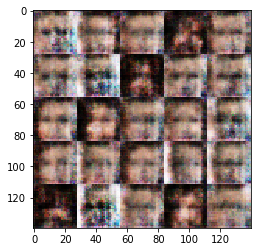

Epoch 1/1 Batch 610/6331... Discriminator Loss: 0.7570 Generator Loss: 1.1651
Epoch 1/1 Batch 620/6331... Discriminator Loss: 0.8975 Generator Loss: 0.8400
Epoch 1/1 Batch 630/6331... Discriminator Loss: 0.2633 Generator Loss: 2.7662
Epoch 1/1 Batch 640/6331... Discriminator Loss: 0.4126 Generator Loss: 1.7152
Epoch 1/1 Batch 650/6331... Discriminator Loss: 0.4129 Generator Loss: 1.4005
Epoch 1/1 Batch 660/6331... Discriminator Loss: 0.3172 Generator Loss: 2.0497
Epoch 1/1 Batch 670/6331... Discriminator Loss: 0.1288 Generator Loss: 4.9831
Epoch 1/1 Batch 680/6331... Discriminator Loss: 0.6171 Generator Loss: 1.8251
Epoch 1/1 Batch 690/6331... Discriminator Loss: 0.4972 Generator Loss: 1.9042
Epoch 1/1 Batch 700/6331... Discriminator Loss: 0.1881 Generator Loss: 4.2399


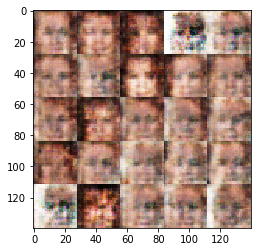

Epoch 1/1 Batch 710/6331... Discriminator Loss: 0.3639 Generator Loss: 2.0456
Epoch 1/1 Batch 720/6331... Discriminator Loss: 0.2277 Generator Loss: 2.7617
Epoch 1/1 Batch 730/6331... Discriminator Loss: 0.4625 Generator Loss: 1.6544
Epoch 1/1 Batch 740/6331... Discriminator Loss: 0.3800 Generator Loss: 2.2893
Epoch 1/1 Batch 750/6331... Discriminator Loss: 0.7205 Generator Loss: 1.4702
Epoch 1/1 Batch 760/6331... Discriminator Loss: 0.4012 Generator Loss: 2.2574
Epoch 1/1 Batch 770/6331... Discriminator Loss: 0.5434 Generator Loss: 1.6228
Epoch 1/1 Batch 780/6331... Discriminator Loss: 0.3244 Generator Loss: 1.8066
Epoch 1/1 Batch 790/6331... Discriminator Loss: 0.5518 Generator Loss: 2.8117
Epoch 1/1 Batch 800/6331... Discriminator Loss: 0.2036 Generator Loss: 3.3946


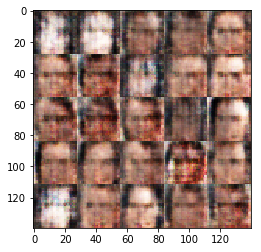

Epoch 1/1 Batch 810/6331... Discriminator Loss: 0.2322 Generator Loss: 2.4315
Epoch 1/1 Batch 820/6331... Discriminator Loss: 0.2716 Generator Loss: 4.1612
Epoch 1/1 Batch 830/6331... Discriminator Loss: 0.4265 Generator Loss: 3.4551
Epoch 1/1 Batch 840/6331... Discriminator Loss: 0.3372 Generator Loss: 1.7586
Epoch 1/1 Batch 850/6331... Discriminator Loss: 0.3539 Generator Loss: 4.0363
Epoch 1/1 Batch 860/6331... Discriminator Loss: 0.2246 Generator Loss: 3.3108
Epoch 1/1 Batch 870/6331... Discriminator Loss: 0.2821 Generator Loss: 3.8343
Epoch 1/1 Batch 880/6331... Discriminator Loss: 0.2380 Generator Loss: 2.3529
Epoch 1/1 Batch 890/6331... Discriminator Loss: 0.3229 Generator Loss: 4.1493
Epoch 1/1 Batch 900/6331... Discriminator Loss: 0.9075 Generator Loss: 1.0305


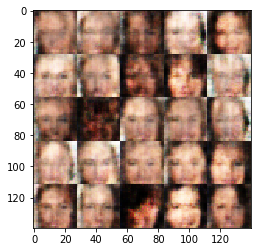

Epoch 1/1 Batch 910/6331... Discriminator Loss: 0.4111 Generator Loss: 2.1005
Epoch 1/1 Batch 920/6331... Discriminator Loss: 0.2816 Generator Loss: 3.1360
Epoch 1/1 Batch 930/6331... Discriminator Loss: 0.3809 Generator Loss: 1.9533
Epoch 1/1 Batch 940/6331... Discriminator Loss: 0.7689 Generator Loss: 1.0985
Epoch 1/1 Batch 950/6331... Discriminator Loss: 0.2537 Generator Loss: 3.0596
Epoch 1/1 Batch 960/6331... Discriminator Loss: 0.4250 Generator Loss: 4.5171
Epoch 1/1 Batch 970/6331... Discriminator Loss: 0.4302 Generator Loss: 4.4368
Epoch 1/1 Batch 980/6331... Discriminator Loss: 0.1629 Generator Loss: 2.8687
Epoch 1/1 Batch 990/6331... Discriminator Loss: 0.2860 Generator Loss: 2.5505
Epoch 1/1 Batch 1000/6331... Discriminator Loss: 0.1910 Generator Loss: 4.3455


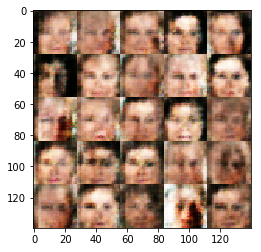

Epoch 1/1 Batch 1010/6331... Discriminator Loss: 0.3806 Generator Loss: 1.8441
Epoch 1/1 Batch 1020/6331... Discriminator Loss: 0.2335 Generator Loss: 3.2794
Epoch 1/1 Batch 1030/6331... Discriminator Loss: 0.3609 Generator Loss: 2.0435
Epoch 1/1 Batch 1040/6331... Discriminator Loss: 0.2431 Generator Loss: 3.2079
Epoch 1/1 Batch 1050/6331... Discriminator Loss: 0.3513 Generator Loss: 2.0384
Epoch 1/1 Batch 1060/6331... Discriminator Loss: 0.3719 Generator Loss: 1.9377
Epoch 1/1 Batch 1070/6331... Discriminator Loss: 0.8947 Generator Loss: 5.3747
Epoch 1/1 Batch 1080/6331... Discriminator Loss: 0.6435 Generator Loss: 1.1941
Epoch 1/1 Batch 1090/6331... Discriminator Loss: 0.7204 Generator Loss: 1.1467
Epoch 1/1 Batch 1100/6331... Discriminator Loss: 1.0336 Generator Loss: 7.3543


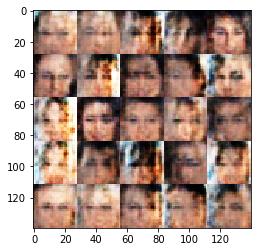

Epoch 1/1 Batch 1110/6331... Discriminator Loss: 0.5129 Generator Loss: 1.8651
Epoch 1/1 Batch 1120/6331... Discriminator Loss: 0.3191 Generator Loss: 3.3040
Epoch 1/1 Batch 1130/6331... Discriminator Loss: 0.3860 Generator Loss: 2.1582
Epoch 1/1 Batch 1140/6331... Discriminator Loss: 0.4503 Generator Loss: 1.7105
Epoch 1/1 Batch 1150/6331... Discriminator Loss: 0.4987 Generator Loss: 3.7628
Epoch 1/1 Batch 1160/6331... Discriminator Loss: 0.2311 Generator Loss: 2.5094
Epoch 1/1 Batch 1170/6331... Discriminator Loss: 0.3600 Generator Loss: 3.6864
Epoch 1/1 Batch 1180/6331... Discriminator Loss: 1.8149 Generator Loss: 0.6788
Epoch 1/1 Batch 1190/6331... Discriminator Loss: 0.5164 Generator Loss: 1.3975
Epoch 1/1 Batch 1200/6331... Discriminator Loss: 0.5580 Generator Loss: 1.5933


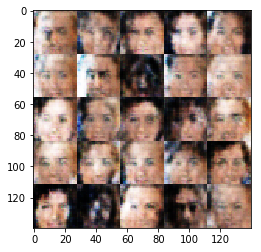

Epoch 1/1 Batch 1210/6331... Discriminator Loss: 0.5420 Generator Loss: 5.3209
Epoch 1/1 Batch 1220/6331... Discriminator Loss: 0.2448 Generator Loss: 3.1546
Epoch 1/1 Batch 1230/6331... Discriminator Loss: 0.2258 Generator Loss: 3.4417
Epoch 1/1 Batch 1240/6331... Discriminator Loss: 0.5281 Generator Loss: 1.9581
Epoch 1/1 Batch 1250/6331... Discriminator Loss: 0.3227 Generator Loss: 2.3037
Epoch 1/1 Batch 1260/6331... Discriminator Loss: 0.1450 Generator Loss: 2.8652
Epoch 1/1 Batch 1270/6331... Discriminator Loss: 0.4177 Generator Loss: 1.7230
Epoch 1/1 Batch 1280/6331... Discriminator Loss: 0.4223 Generator Loss: 1.9672
Epoch 1/1 Batch 1290/6331... Discriminator Loss: 0.3762 Generator Loss: 1.7289
Epoch 1/1 Batch 1300/6331... Discriminator Loss: 0.3350 Generator Loss: 2.5230


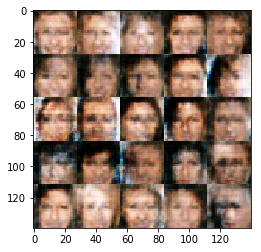

Epoch 1/1 Batch 1310/6331... Discriminator Loss: 0.2243 Generator Loss: 2.5062
Epoch 1/1 Batch 1320/6331... Discriminator Loss: 0.1783 Generator Loss: 2.8931
Epoch 1/1 Batch 1330/6331... Discriminator Loss: 0.3529 Generator Loss: 3.6107
Epoch 1/1 Batch 1340/6331... Discriminator Loss: 0.3144 Generator Loss: 1.7368
Epoch 1/1 Batch 1350/6331... Discriminator Loss: 0.2751 Generator Loss: 2.6144
Epoch 1/1 Batch 1360/6331... Discriminator Loss: 0.2269 Generator Loss: 2.2856
Epoch 1/1 Batch 1370/6331... Discriminator Loss: 0.5554 Generator Loss: 1.2041
Epoch 1/1 Batch 1380/6331... Discriminator Loss: 0.2572 Generator Loss: 2.9495
Epoch 1/1 Batch 1390/6331... Discriminator Loss: 0.4789 Generator Loss: 1.8408
Epoch 1/1 Batch 1400/6331... Discriminator Loss: 0.7798 Generator Loss: 1.3326


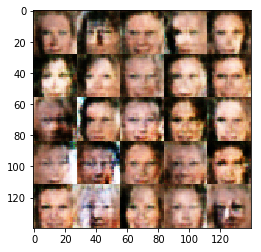

Epoch 1/1 Batch 1410/6331... Discriminator Loss: 0.2482 Generator Loss: 3.1856
Epoch 1/1 Batch 1420/6331... Discriminator Loss: 0.2977 Generator Loss: 3.6190
Epoch 1/1 Batch 1430/6331... Discriminator Loss: 0.3917 Generator Loss: 2.8601
Epoch 1/1 Batch 1440/6331... Discriminator Loss: 0.2641 Generator Loss: 2.6959
Epoch 1/1 Batch 1450/6331... Discriminator Loss: 0.5498 Generator Loss: 1.2017
Epoch 1/1 Batch 1460/6331... Discriminator Loss: 0.8350 Generator Loss: 5.0223
Epoch 1/1 Batch 1470/6331... Discriminator Loss: 0.3535 Generator Loss: 3.5636
Epoch 1/1 Batch 1480/6331... Discriminator Loss: 0.3302 Generator Loss: 2.4576
Epoch 1/1 Batch 1490/6331... Discriminator Loss: 0.2896 Generator Loss: 3.6533
Epoch 1/1 Batch 1500/6331... Discriminator Loss: 0.2623 Generator Loss: 2.3719


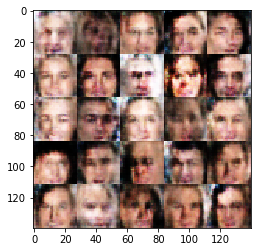

Epoch 1/1 Batch 1510/6331... Discriminator Loss: 0.4613 Generator Loss: 1.8149
Epoch 1/1 Batch 1520/6331... Discriminator Loss: 0.5498 Generator Loss: 1.6559
Epoch 1/1 Batch 1530/6331... Discriminator Loss: 1.0667 Generator Loss: 4.7277
Epoch 1/1 Batch 1540/6331... Discriminator Loss: 0.2630 Generator Loss: 2.3629
Epoch 1/1 Batch 1550/6331... Discriminator Loss: 0.2100 Generator Loss: 3.4856
Epoch 1/1 Batch 1560/6331... Discriminator Loss: 0.1998 Generator Loss: 2.2872
Epoch 1/1 Batch 1570/6331... Discriminator Loss: 0.2417 Generator Loss: 2.9508
Epoch 1/1 Batch 1580/6331... Discriminator Loss: 0.5528 Generator Loss: 2.0587
Epoch 1/1 Batch 1590/6331... Discriminator Loss: 0.5604 Generator Loss: 1.6212
Epoch 1/1 Batch 1600/6331... Discriminator Loss: 0.5010 Generator Loss: 1.4597


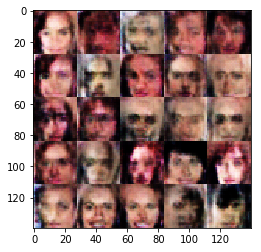

Epoch 1/1 Batch 1610/6331... Discriminator Loss: 0.6945 Generator Loss: 1.2214
Epoch 1/1 Batch 1620/6331... Discriminator Loss: 0.2012 Generator Loss: 2.8248
Epoch 1/1 Batch 1630/6331... Discriminator Loss: 0.4622 Generator Loss: 1.5262
Epoch 1/1 Batch 1640/6331... Discriminator Loss: 0.5634 Generator Loss: 1.0638
Epoch 1/1 Batch 1650/6331... Discriminator Loss: 0.2754 Generator Loss: 2.3096
Epoch 1/1 Batch 1660/6331... Discriminator Loss: 0.3206 Generator Loss: 2.1360
Epoch 1/1 Batch 1670/6331... Discriminator Loss: 0.5445 Generator Loss: 2.7491
Epoch 1/1 Batch 1680/6331... Discriminator Loss: 1.1703 Generator Loss: 5.0832
Epoch 1/1 Batch 1690/6331... Discriminator Loss: 0.3480 Generator Loss: 3.7445
Epoch 1/1 Batch 1700/6331... Discriminator Loss: 0.3883 Generator Loss: 1.9140


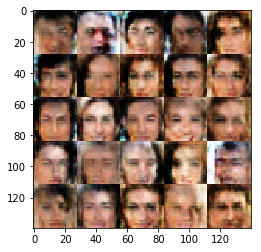

Epoch 1/1 Batch 1710/6331... Discriminator Loss: 0.2818 Generator Loss: 3.1334
Epoch 1/1 Batch 1720/6331... Discriminator Loss: 0.3053 Generator Loss: 2.8655
Epoch 1/1 Batch 1730/6331... Discriminator Loss: 0.3409 Generator Loss: 3.2284
Epoch 1/1 Batch 1740/6331... Discriminator Loss: 0.3649 Generator Loss: 1.5647
Epoch 1/1 Batch 1750/6331... Discriminator Loss: 0.3536 Generator Loss: 2.3071
Epoch 1/1 Batch 1760/6331... Discriminator Loss: 0.3048 Generator Loss: 3.2044
Epoch 1/1 Batch 1770/6331... Discriminator Loss: 0.2935 Generator Loss: 2.8319
Epoch 1/1 Batch 1780/6331... Discriminator Loss: 1.2377 Generator Loss: 0.6972
Epoch 1/1 Batch 1790/6331... Discriminator Loss: 0.6948 Generator Loss: 1.5011
Epoch 1/1 Batch 1800/6331... Discriminator Loss: 0.3681 Generator Loss: 2.4073


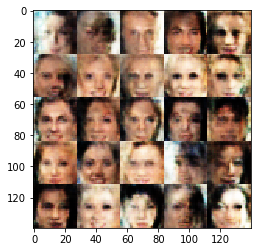

Epoch 1/1 Batch 1810/6331... Discriminator Loss: 0.2761 Generator Loss: 3.4088
Epoch 1/1 Batch 1820/6331... Discriminator Loss: 0.3536 Generator Loss: 3.2005
Epoch 1/1 Batch 1830/6331... Discriminator Loss: 0.4161 Generator Loss: 2.0367
Epoch 1/1 Batch 1840/6331... Discriminator Loss: 0.4010 Generator Loss: 4.1265
Epoch 1/1 Batch 1850/6331... Discriminator Loss: 0.3589 Generator Loss: 3.0453
Epoch 1/1 Batch 1860/6331... Discriminator Loss: 0.3547 Generator Loss: 2.4217
Epoch 1/1 Batch 1870/6331... Discriminator Loss: 0.3285 Generator Loss: 2.8309
Epoch 1/1 Batch 1880/6331... Discriminator Loss: 0.3178 Generator Loss: 2.3812
Epoch 1/1 Batch 1890/6331... Discriminator Loss: 0.5943 Generator Loss: 1.2203
Epoch 1/1 Batch 1900/6331... Discriminator Loss: 0.3705 Generator Loss: 3.4257


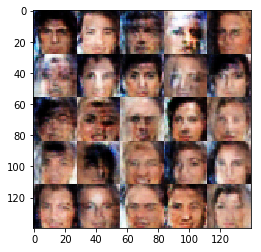

Epoch 1/1 Batch 1910/6331... Discriminator Loss: 0.2843 Generator Loss: 1.6684
Epoch 1/1 Batch 1920/6331... Discriminator Loss: 0.4703 Generator Loss: 1.3127
Epoch 1/1 Batch 1930/6331... Discriminator Loss: 0.3722 Generator Loss: 2.6031
Epoch 1/1 Batch 1940/6331... Discriminator Loss: 0.4353 Generator Loss: 2.1725
Epoch 1/1 Batch 1950/6331... Discriminator Loss: 0.4412 Generator Loss: 1.7428
Epoch 1/1 Batch 1960/6331... Discriminator Loss: 0.5136 Generator Loss: 4.0305
Epoch 1/1 Batch 1970/6331... Discriminator Loss: 0.3048 Generator Loss: 2.5622
Epoch 1/1 Batch 1980/6331... Discriminator Loss: 0.2931 Generator Loss: 2.6409
Epoch 1/1 Batch 1990/6331... Discriminator Loss: 0.8333 Generator Loss: 1.0281
Epoch 1/1 Batch 2000/6331... Discriminator Loss: 0.3085 Generator Loss: 2.2197


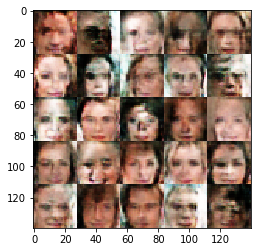

Epoch 1/1 Batch 2010/6331... Discriminator Loss: 0.3371 Generator Loss: 2.6446
Epoch 1/1 Batch 2020/6331... Discriminator Loss: 0.2924 Generator Loss: 2.1718
Epoch 1/1 Batch 2030/6331... Discriminator Loss: 0.5155 Generator Loss: 2.8868
Epoch 1/1 Batch 2040/6331... Discriminator Loss: 0.6065 Generator Loss: 3.6822
Epoch 1/1 Batch 2050/6331... Discriminator Loss: 0.3977 Generator Loss: 1.5448
Epoch 1/1 Batch 2060/6331... Discriminator Loss: 0.2983 Generator Loss: 2.8691
Epoch 1/1 Batch 2070/6331... Discriminator Loss: 0.4712 Generator Loss: 2.5578
Epoch 1/1 Batch 2080/6331... Discriminator Loss: 0.4426 Generator Loss: 1.3061
Epoch 1/1 Batch 2090/6331... Discriminator Loss: 0.3179 Generator Loss: 2.4835
Epoch 1/1 Batch 2100/6331... Discriminator Loss: 0.4382 Generator Loss: 2.2927


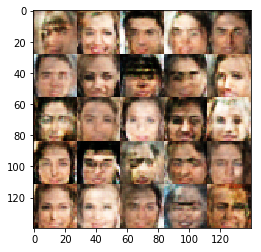

Epoch 1/1 Batch 2110/6331... Discriminator Loss: 0.4839 Generator Loss: 4.5405
Epoch 1/1 Batch 2120/6331... Discriminator Loss: 0.7324 Generator Loss: 3.4754
Epoch 1/1 Batch 2130/6331... Discriminator Loss: 0.3326 Generator Loss: 1.8238
Epoch 1/1 Batch 2140/6331... Discriminator Loss: 0.1993 Generator Loss: 2.7890
Epoch 1/1 Batch 2150/6331... Discriminator Loss: 0.5131 Generator Loss: 4.4383
Epoch 1/1 Batch 2160/6331... Discriminator Loss: 0.6359 Generator Loss: 2.8533
Epoch 1/1 Batch 2170/6331... Discriminator Loss: 0.5276 Generator Loss: 1.5381
Epoch 1/1 Batch 2180/6331... Discriminator Loss: 0.4054 Generator Loss: 2.6546
Epoch 1/1 Batch 2190/6331... Discriminator Loss: 0.4856 Generator Loss: 1.3335
Epoch 1/1 Batch 2200/6331... Discriminator Loss: 0.7271 Generator Loss: 1.1157


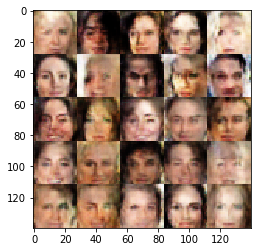

Epoch 1/1 Batch 2210/6331... Discriminator Loss: 0.2926 Generator Loss: 2.2688
Epoch 1/1 Batch 2220/6331... Discriminator Loss: 0.8340 Generator Loss: 0.8024
Epoch 1/1 Batch 2230/6331... Discriminator Loss: 0.8267 Generator Loss: 0.8572
Epoch 1/1 Batch 2240/6331... Discriminator Loss: 0.3286 Generator Loss: 1.9961
Epoch 1/1 Batch 2250/6331... Discriminator Loss: 0.3177 Generator Loss: 1.7467
Epoch 1/1 Batch 2260/6331... Discriminator Loss: 0.4437 Generator Loss: 1.8095
Epoch 1/1 Batch 2270/6331... Discriminator Loss: 0.3873 Generator Loss: 2.3325
Epoch 1/1 Batch 2280/6331... Discriminator Loss: 0.2131 Generator Loss: 2.1371
Epoch 1/1 Batch 2290/6331... Discriminator Loss: 0.2300 Generator Loss: 2.0840
Epoch 1/1 Batch 2300/6331... Discriminator Loss: 0.5668 Generator Loss: 1.7480


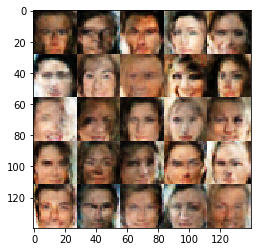

Epoch 1/1 Batch 2310/6331... Discriminator Loss: 0.5260 Generator Loss: 2.8864
Epoch 1/1 Batch 2320/6331... Discriminator Loss: 0.5762 Generator Loss: 3.4700
Epoch 1/1 Batch 2330/6331... Discriminator Loss: 0.5614 Generator Loss: 1.3471
Epoch 1/1 Batch 2340/6331... Discriminator Loss: 0.4792 Generator Loss: 3.2425
Epoch 1/1 Batch 2350/6331... Discriminator Loss: 0.3742 Generator Loss: 1.6447
Epoch 1/1 Batch 2360/6331... Discriminator Loss: 0.4815 Generator Loss: 2.0772
Epoch 1/1 Batch 2370/6331... Discriminator Loss: 0.8099 Generator Loss: 4.2211
Epoch 1/1 Batch 2380/6331... Discriminator Loss: 0.6525 Generator Loss: 4.0412
Epoch 1/1 Batch 2390/6331... Discriminator Loss: 0.3738 Generator Loss: 2.0396
Epoch 1/1 Batch 2400/6331... Discriminator Loss: 0.3960 Generator Loss: 2.1098


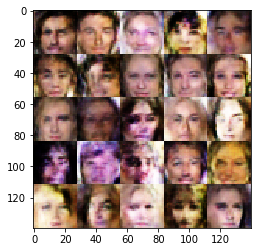

Epoch 1/1 Batch 2410/6331... Discriminator Loss: 0.8662 Generator Loss: 0.8341
Epoch 1/1 Batch 2420/6331... Discriminator Loss: 0.5596 Generator Loss: 1.7509
Epoch 1/1 Batch 2430/6331... Discriminator Loss: 0.8806 Generator Loss: 1.0470
Epoch 1/1 Batch 2440/6331... Discriminator Loss: 0.5615 Generator Loss: 1.4276
Epoch 1/1 Batch 2450/6331... Discriminator Loss: 0.4685 Generator Loss: 4.0870
Epoch 1/1 Batch 2460/6331... Discriminator Loss: 0.8316 Generator Loss: 1.1273
Epoch 1/1 Batch 2470/6331... Discriminator Loss: 0.5363 Generator Loss: 1.7149
Epoch 1/1 Batch 2480/6331... Discriminator Loss: 0.2704 Generator Loss: 2.2412
Epoch 1/1 Batch 2490/6331... Discriminator Loss: 0.4703 Generator Loss: 1.5834
Epoch 1/1 Batch 2500/6331... Discriminator Loss: 0.4597 Generator Loss: 2.2693


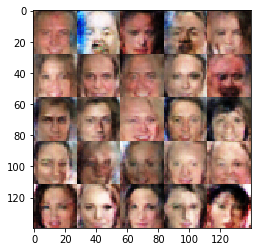

Epoch 1/1 Batch 2510/6331... Discriminator Loss: 0.3401 Generator Loss: 2.3769
Epoch 1/1 Batch 2520/6331... Discriminator Loss: 0.2868 Generator Loss: 2.3762
Epoch 1/1 Batch 2530/6331... Discriminator Loss: 0.3094 Generator Loss: 2.6569
Epoch 1/1 Batch 2540/6331... Discriminator Loss: 0.4502 Generator Loss: 2.3341
Epoch 1/1 Batch 2550/6331... Discriminator Loss: 0.3144 Generator Loss: 2.6072
Epoch 1/1 Batch 2560/6331... Discriminator Loss: 1.1007 Generator Loss: 0.6906
Epoch 1/1 Batch 2570/6331... Discriminator Loss: 0.3358 Generator Loss: 2.4384
Epoch 1/1 Batch 2580/6331... Discriminator Loss: 0.2698 Generator Loss: 1.8758
Epoch 1/1 Batch 2590/6331... Discriminator Loss: 0.3383 Generator Loss: 2.1655
Epoch 1/1 Batch 2600/6331... Discriminator Loss: 0.8833 Generator Loss: 1.0943


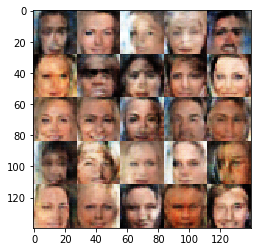

Epoch 1/1 Batch 2610/6331... Discriminator Loss: 0.4362 Generator Loss: 2.5382
Epoch 1/1 Batch 2620/6331... Discriminator Loss: 0.4048 Generator Loss: 1.5816
Epoch 1/1 Batch 2630/6331... Discriminator Loss: 0.3576 Generator Loss: 3.0513
Epoch 1/1 Batch 2640/6331... Discriminator Loss: 0.3447 Generator Loss: 3.7747
Epoch 1/1 Batch 2650/6331... Discriminator Loss: 0.2544 Generator Loss: 2.6232
Epoch 1/1 Batch 2660/6331... Discriminator Loss: 0.4267 Generator Loss: 3.3762
Epoch 1/1 Batch 2670/6331... Discriminator Loss: 0.2723 Generator Loss: 2.5438
Epoch 1/1 Batch 2680/6331... Discriminator Loss: 0.6777 Generator Loss: 1.1320
Epoch 1/1 Batch 2690/6331... Discriminator Loss: 0.2816 Generator Loss: 2.2613
Epoch 1/1 Batch 2700/6331... Discriminator Loss: 0.5659 Generator Loss: 3.7734


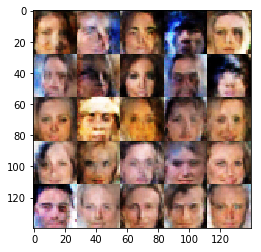

Epoch 1/1 Batch 2710/6331... Discriminator Loss: 0.2601 Generator Loss: 2.1262
Epoch 1/1 Batch 2720/6331... Discriminator Loss: 0.2232 Generator Loss: 3.1748
Epoch 1/1 Batch 2730/6331... Discriminator Loss: 0.3096 Generator Loss: 2.9267
Epoch 1/1 Batch 2740/6331... Discriminator Loss: 0.8238 Generator Loss: 4.3939
Epoch 1/1 Batch 2750/6331... Discriminator Loss: 0.6087 Generator Loss: 1.2283
Epoch 1/1 Batch 2760/6331... Discriminator Loss: 0.3119 Generator Loss: 2.6334
Epoch 1/1 Batch 2770/6331... Discriminator Loss: 0.4758 Generator Loss: 2.3649
Epoch 1/1 Batch 2780/6331... Discriminator Loss: 0.2902 Generator Loss: 1.9073
Epoch 1/1 Batch 2790/6331... Discriminator Loss: 0.2829 Generator Loss: 2.2221
Epoch 1/1 Batch 2800/6331... Discriminator Loss: 0.2333 Generator Loss: 2.5303


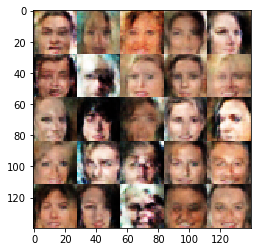

Epoch 1/1 Batch 2810/6331... Discriminator Loss: 0.3912 Generator Loss: 1.9359
Epoch 1/1 Batch 2820/6331... Discriminator Loss: 0.4829 Generator Loss: 1.4726
Epoch 1/1 Batch 2830/6331... Discriminator Loss: 0.3614 Generator Loss: 2.2017
Epoch 1/1 Batch 2840/6331... Discriminator Loss: 0.5971 Generator Loss: 1.1197
Epoch 1/1 Batch 2850/6331... Discriminator Loss: 0.2923 Generator Loss: 2.8374
Epoch 1/1 Batch 2860/6331... Discriminator Loss: 0.3197 Generator Loss: 1.5453
Epoch 1/1 Batch 2870/6331... Discriminator Loss: 0.2350 Generator Loss: 2.4417
Epoch 1/1 Batch 2880/6331... Discriminator Loss: 0.4433 Generator Loss: 1.8173
Epoch 1/1 Batch 2890/6331... Discriminator Loss: 0.4198 Generator Loss: 2.4175
Epoch 1/1 Batch 2900/6331... Discriminator Loss: 0.6097 Generator Loss: 4.3087


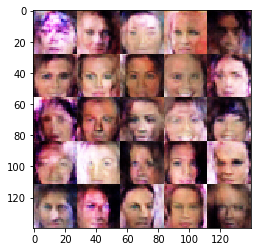

Epoch 1/1 Batch 2910/6331... Discriminator Loss: 0.1691 Generator Loss: 2.8480
Epoch 1/1 Batch 2920/6331... Discriminator Loss: 0.7175 Generator Loss: 3.7696
Epoch 1/1 Batch 2930/6331... Discriminator Loss: 0.2579 Generator Loss: 2.6684
Epoch 1/1 Batch 2940/6331... Discriminator Loss: 0.2837 Generator Loss: 2.8207
Epoch 1/1 Batch 2950/6331... Discriminator Loss: 0.5497 Generator Loss: 1.1310
Epoch 1/1 Batch 2960/6331... Discriminator Loss: 0.5309 Generator Loss: 0.9782
Epoch 1/1 Batch 2970/6331... Discriminator Loss: 0.3111 Generator Loss: 1.7871
Epoch 1/1 Batch 2980/6331... Discriminator Loss: 0.1653 Generator Loss: 2.8463
Epoch 1/1 Batch 2990/6331... Discriminator Loss: 0.5198 Generator Loss: 1.3319
Epoch 1/1 Batch 3000/6331... Discriminator Loss: 0.3471 Generator Loss: 2.3689


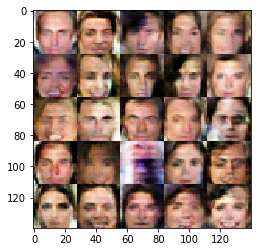

Epoch 1/1 Batch 3010/6331... Discriminator Loss: 0.4179 Generator Loss: 1.8181
Epoch 1/1 Batch 3020/6331... Discriminator Loss: 0.2924 Generator Loss: 1.9775
Epoch 1/1 Batch 3030/6331... Discriminator Loss: 0.3996 Generator Loss: 2.0025
Epoch 1/1 Batch 3040/6331... Discriminator Loss: 0.3483 Generator Loss: 2.0399
Epoch 1/1 Batch 3050/6331... Discriminator Loss: 0.3363 Generator Loss: 2.1285
Epoch 1/1 Batch 3060/6331... Discriminator Loss: 0.4033 Generator Loss: 2.4649
Epoch 1/1 Batch 3070/6331... Discriminator Loss: 0.4422 Generator Loss: 1.6408
Epoch 1/1 Batch 3080/6331... Discriminator Loss: 0.4155 Generator Loss: 1.8038
Epoch 1/1 Batch 3090/6331... Discriminator Loss: 0.4366 Generator Loss: 1.6539
Epoch 1/1 Batch 3100/6331... Discriminator Loss: 0.4862 Generator Loss: 1.5888


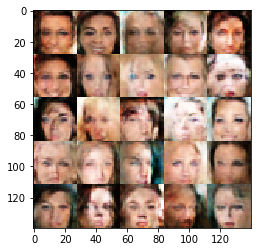

Epoch 1/1 Batch 3110/6331... Discriminator Loss: 0.2851 Generator Loss: 2.2213
Epoch 1/1 Batch 3120/6331... Discriminator Loss: 1.3183 Generator Loss: 0.7466
Epoch 1/1 Batch 3130/6331... Discriminator Loss: 0.3873 Generator Loss: 1.8342
Epoch 1/1 Batch 3140/6331... Discriminator Loss: 0.2550 Generator Loss: 2.7556
Epoch 1/1 Batch 3150/6331... Discriminator Loss: 0.3384 Generator Loss: 3.4003
Epoch 1/1 Batch 3160/6331... Discriminator Loss: 0.3045 Generator Loss: 2.4728
Epoch 1/1 Batch 3170/6331... Discriminator Loss: 0.1941 Generator Loss: 3.8524
Epoch 1/1 Batch 3180/6331... Discriminator Loss: 0.3942 Generator Loss: 2.2031
Epoch 1/1 Batch 3190/6331... Discriminator Loss: 0.6757 Generator Loss: 1.2777
Epoch 1/1 Batch 3200/6331... Discriminator Loss: 0.7088 Generator Loss: 0.9755


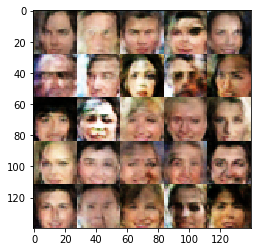

Epoch 1/1 Batch 3210/6331... Discriminator Loss: 0.5192 Generator Loss: 3.7606
Epoch 1/1 Batch 3220/6331... Discriminator Loss: 0.3458 Generator Loss: 2.2032
Epoch 1/1 Batch 3230/6331... Discriminator Loss: 0.3670 Generator Loss: 2.0610
Epoch 1/1 Batch 3240/6331... Discriminator Loss: 0.3784 Generator Loss: 1.8744
Epoch 1/1 Batch 3250/6331... Discriminator Loss: 0.3716 Generator Loss: 2.5334
Epoch 1/1 Batch 3260/6331... Discriminator Loss: 0.3032 Generator Loss: 2.0308
Epoch 1/1 Batch 3270/6331... Discriminator Loss: 0.3274 Generator Loss: 3.3328
Epoch 1/1 Batch 3280/6331... Discriminator Loss: 0.4392 Generator Loss: 3.5996
Epoch 1/1 Batch 3290/6331... Discriminator Loss: 0.3667 Generator Loss: 1.7035
Epoch 1/1 Batch 3300/6331... Discriminator Loss: 0.2720 Generator Loss: 2.3074


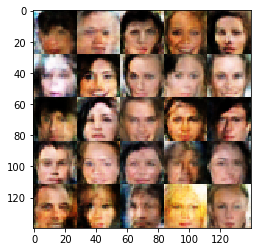

Epoch 1/1 Batch 3310/6331... Discriminator Loss: 0.5894 Generator Loss: 4.3996
Epoch 1/1 Batch 3320/6331... Discriminator Loss: 0.2764 Generator Loss: 2.2915
Epoch 1/1 Batch 3330/6331... Discriminator Loss: 0.9391 Generator Loss: 1.3001
Epoch 1/1 Batch 3340/6331... Discriminator Loss: 0.2082 Generator Loss: 3.3429
Epoch 1/1 Batch 3350/6331... Discriminator Loss: 0.3755 Generator Loss: 2.6076
Epoch 1/1 Batch 3360/6331... Discriminator Loss: 0.3790 Generator Loss: 1.8980
Epoch 1/1 Batch 3370/6331... Discriminator Loss: 1.7065 Generator Loss: 0.3909
Epoch 1/1 Batch 3380/6331... Discriminator Loss: 0.2670 Generator Loss: 2.7214
Epoch 1/1 Batch 3390/6331... Discriminator Loss: 0.3197 Generator Loss: 3.0426
Epoch 1/1 Batch 3400/6331... Discriminator Loss: 0.2074 Generator Loss: 2.6598


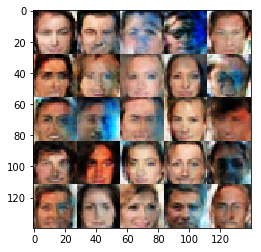

Epoch 1/1 Batch 3410/6331... Discriminator Loss: 0.2977 Generator Loss: 3.0417
Epoch 1/1 Batch 3420/6331... Discriminator Loss: 0.1848 Generator Loss: 2.7136
Epoch 1/1 Batch 3430/6331... Discriminator Loss: 0.4550 Generator Loss: 1.5668
Epoch 1/1 Batch 3440/6331... Discriminator Loss: 0.2567 Generator Loss: 2.5871
Epoch 1/1 Batch 3450/6331... Discriminator Loss: 0.3035 Generator Loss: 2.2812
Epoch 1/1 Batch 3460/6331... Discriminator Loss: 0.2737 Generator Loss: 2.4385
Epoch 1/1 Batch 3470/6331... Discriminator Loss: 0.5913 Generator Loss: 3.9579
Epoch 1/1 Batch 3480/6331... Discriminator Loss: 0.8049 Generator Loss: 1.1688
Epoch 1/1 Batch 3490/6331... Discriminator Loss: 0.4337 Generator Loss: 1.4501
Epoch 1/1 Batch 3500/6331... Discriminator Loss: 0.2537 Generator Loss: 2.3509


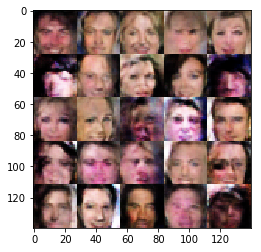

Epoch 1/1 Batch 3510/6331... Discriminator Loss: 0.2625 Generator Loss: 2.6428
Epoch 1/1 Batch 3520/6331... Discriminator Loss: 0.2764 Generator Loss: 2.8985
Epoch 1/1 Batch 3530/6331... Discriminator Loss: 0.3529 Generator Loss: 1.9635
Epoch 1/1 Batch 3540/6331... Discriminator Loss: 0.4198 Generator Loss: 1.2975
Epoch 1/1 Batch 3550/6331... Discriminator Loss: 0.3693 Generator Loss: 2.8688
Epoch 1/1 Batch 3560/6331... Discriminator Loss: 0.4118 Generator Loss: 2.2020
Epoch 1/1 Batch 3570/6331... Discriminator Loss: 0.2438 Generator Loss: 3.1602
Epoch 1/1 Batch 3580/6331... Discriminator Loss: 0.2601 Generator Loss: 2.4354
Epoch 1/1 Batch 3590/6331... Discriminator Loss: 0.2045 Generator Loss: 2.8289
Epoch 1/1 Batch 3600/6331... Discriminator Loss: 1.4540 Generator Loss: 5.7906


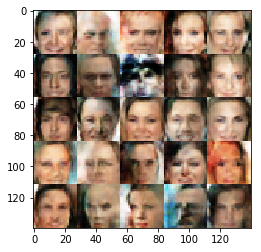

Epoch 1/1 Batch 3610/6331... Discriminator Loss: 0.7355 Generator Loss: 1.0674
Epoch 1/1 Batch 3620/6331... Discriminator Loss: 0.3383 Generator Loss: 2.2635
Epoch 1/1 Batch 3630/6331... Discriminator Loss: 0.2410 Generator Loss: 2.0730
Epoch 1/1 Batch 3640/6331... Discriminator Loss: 0.2265 Generator Loss: 2.1853
Epoch 1/1 Batch 3650/6331... Discriminator Loss: 0.2564 Generator Loss: 2.3017
Epoch 1/1 Batch 3660/6331... Discriminator Loss: 0.4006 Generator Loss: 1.7014
Epoch 1/1 Batch 3670/6331... Discriminator Loss: 0.2675 Generator Loss: 2.7479
Epoch 1/1 Batch 3680/6331... Discriminator Loss: 0.3736 Generator Loss: 2.6111
Epoch 1/1 Batch 3690/6331... Discriminator Loss: 0.5707 Generator Loss: 1.3608
Epoch 1/1 Batch 3700/6331... Discriminator Loss: 0.3852 Generator Loss: 2.5266


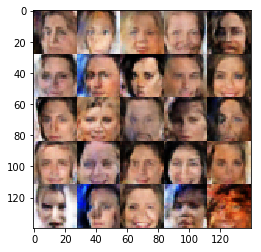

Epoch 1/1 Batch 3710/6331... Discriminator Loss: 0.7410 Generator Loss: 1.2826
Epoch 1/1 Batch 3720/6331... Discriminator Loss: 0.3263 Generator Loss: 2.2415
Epoch 1/1 Batch 3730/6331... Discriminator Loss: 0.2818 Generator Loss: 2.8920
Epoch 1/1 Batch 3740/6331... Discriminator Loss: 0.4563 Generator Loss: 1.6248
Epoch 1/1 Batch 3750/6331... Discriminator Loss: 0.2403 Generator Loss: 2.2305
Epoch 1/1 Batch 3760/6331... Discriminator Loss: 0.2869 Generator Loss: 2.5748
Epoch 1/1 Batch 3770/6331... Discriminator Loss: 0.2966 Generator Loss: 2.2007
Epoch 1/1 Batch 3780/6331... Discriminator Loss: 0.2207 Generator Loss: 3.0764
Epoch 1/1 Batch 3790/6331... Discriminator Loss: 0.2737 Generator Loss: 2.5019
Epoch 1/1 Batch 3800/6331... Discriminator Loss: 0.3342 Generator Loss: 2.6511


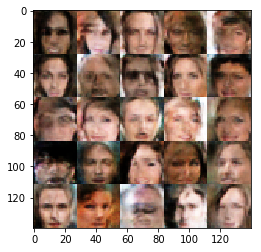

Epoch 1/1 Batch 3810/6331... Discriminator Loss: 0.2117 Generator Loss: 2.1478
Epoch 1/1 Batch 3820/6331... Discriminator Loss: 0.2274 Generator Loss: 3.5611
Epoch 1/1 Batch 3830/6331... Discriminator Loss: 0.2338 Generator Loss: 2.7202
Epoch 1/1 Batch 3840/6331... Discriminator Loss: 0.3756 Generator Loss: 1.5070
Epoch 1/1 Batch 3850/6331... Discriminator Loss: 0.1582 Generator Loss: 2.8037
Epoch 1/1 Batch 3860/6331... Discriminator Loss: 0.2275 Generator Loss: 3.3749
Epoch 1/1 Batch 3870/6331... Discriminator Loss: 0.1906 Generator Loss: 2.5202
Epoch 1/1 Batch 3880/6331... Discriminator Loss: 0.7566 Generator Loss: 1.1655
Epoch 1/1 Batch 3890/6331... Discriminator Loss: 0.1765 Generator Loss: 2.2965
Epoch 1/1 Batch 3900/6331... Discriminator Loss: 0.2157 Generator Loss: 2.6210


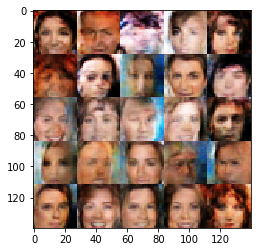

Epoch 1/1 Batch 3910/6331... Discriminator Loss: 0.4424 Generator Loss: 3.2650
Epoch 1/1 Batch 3920/6331... Discriminator Loss: 0.2945 Generator Loss: 2.4823
Epoch 1/1 Batch 3930/6331... Discriminator Loss: 0.4297 Generator Loss: 1.7547
Epoch 1/1 Batch 3940/6331... Discriminator Loss: 0.4599 Generator Loss: 3.7473
Epoch 1/1 Batch 3950/6331... Discriminator Loss: 0.2538 Generator Loss: 2.8910
Epoch 1/1 Batch 3960/6331... Discriminator Loss: 0.1730 Generator Loss: 2.6647
Epoch 1/1 Batch 3970/6331... Discriminator Loss: 0.4669 Generator Loss: 1.7469
Epoch 1/1 Batch 3980/6331... Discriminator Loss: 0.4014 Generator Loss: 1.5799
Epoch 1/1 Batch 3990/6331... Discriminator Loss: 0.3862 Generator Loss: 1.8407
Epoch 1/1 Batch 4000/6331... Discriminator Loss: 0.2280 Generator Loss: 3.3357


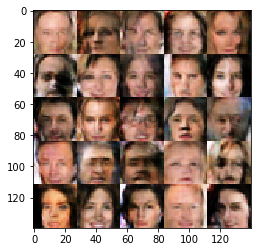

Epoch 1/1 Batch 4010/6331... Discriminator Loss: 0.1975 Generator Loss: 2.8645
Epoch 1/1 Batch 4020/6331... Discriminator Loss: 0.2770 Generator Loss: 2.7743
Epoch 1/1 Batch 4030/6331... Discriminator Loss: 0.3345 Generator Loss: 2.5884
Epoch 1/1 Batch 4040/6331... Discriminator Loss: 0.4601 Generator Loss: 1.5322
Epoch 1/1 Batch 4050/6331... Discriminator Loss: 0.3313 Generator Loss: 2.3025
Epoch 1/1 Batch 4060/6331... Discriminator Loss: 0.2073 Generator Loss: 2.2475
Epoch 1/1 Batch 4070/6331... Discriminator Loss: 0.3655 Generator Loss: 1.7568
Epoch 1/1 Batch 4080/6331... Discriminator Loss: 0.3254 Generator Loss: 1.8782
Epoch 1/1 Batch 4090/6331... Discriminator Loss: 0.3249 Generator Loss: 2.2536
Epoch 1/1 Batch 4100/6331... Discriminator Loss: 0.3313 Generator Loss: 1.8221


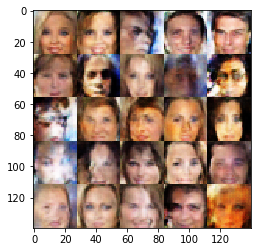

Epoch 1/1 Batch 4110/6331... Discriminator Loss: 0.3284 Generator Loss: 2.5543
Epoch 1/1 Batch 4120/6331... Discriminator Loss: 0.3027 Generator Loss: 2.8683
Epoch 1/1 Batch 4130/6331... Discriminator Loss: 0.7011 Generator Loss: 0.9037
Epoch 1/1 Batch 4140/6331... Discriminator Loss: 0.3087 Generator Loss: 2.0827
Epoch 1/1 Batch 4150/6331... Discriminator Loss: 0.1154 Generator Loss: 2.5295
Epoch 1/1 Batch 4160/6331... Discriminator Loss: 0.2673 Generator Loss: 2.9495
Epoch 1/1 Batch 4170/6331... Discriminator Loss: 0.3878 Generator Loss: 1.8099
Epoch 1/1 Batch 4180/6331... Discriminator Loss: 0.4352 Generator Loss: 3.1719
Epoch 1/1 Batch 4190/6331... Discriminator Loss: 0.7789 Generator Loss: 4.5071
Epoch 1/1 Batch 4200/6331... Discriminator Loss: 0.2800 Generator Loss: 2.8438


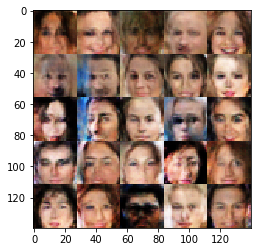

Epoch 1/1 Batch 4210/6331... Discriminator Loss: 0.2299 Generator Loss: 2.2167
Epoch 1/1 Batch 4220/6331... Discriminator Loss: 0.2852 Generator Loss: 2.4080
Epoch 1/1 Batch 4230/6331... Discriminator Loss: 0.1919 Generator Loss: 3.2679
Epoch 1/1 Batch 4240/6331... Discriminator Loss: 0.3149 Generator Loss: 2.6069
Epoch 1/1 Batch 4250/6331... Discriminator Loss: 0.1252 Generator Loss: 3.5924
Epoch 1/1 Batch 4260/6331... Discriminator Loss: 0.2858 Generator Loss: 3.3103
Epoch 1/1 Batch 4270/6331... Discriminator Loss: 0.1528 Generator Loss: 3.3177
Epoch 1/1 Batch 4280/6331... Discriminator Loss: 0.2084 Generator Loss: 2.9986
Epoch 1/1 Batch 4290/6331... Discriminator Loss: 0.2619 Generator Loss: 2.4392
Epoch 1/1 Batch 4300/6331... Discriminator Loss: 0.5207 Generator Loss: 1.3948


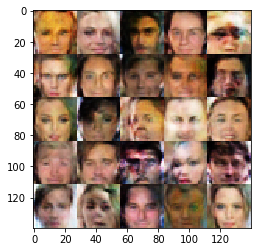

Epoch 1/1 Batch 4310/6331... Discriminator Loss: 0.2325 Generator Loss: 3.1545
Epoch 1/1 Batch 4320/6331... Discriminator Loss: 0.3714 Generator Loss: 2.3242
Epoch 1/1 Batch 4330/6331... Discriminator Loss: 0.1463 Generator Loss: 2.8476
Epoch 1/1 Batch 4340/6331... Discriminator Loss: 0.7624 Generator Loss: 1.3090
Epoch 1/1 Batch 4350/6331... Discriminator Loss: 0.3580 Generator Loss: 1.7446
Epoch 1/1 Batch 4360/6331... Discriminator Loss: 0.7430 Generator Loss: 1.4789
Epoch 1/1 Batch 4370/6331... Discriminator Loss: 0.5378 Generator Loss: 1.4830
Epoch 1/1 Batch 4380/6331... Discriminator Loss: 0.3095 Generator Loss: 3.6385
Epoch 1/1 Batch 4390/6331... Discriminator Loss: 0.5763 Generator Loss: 1.3107
Epoch 1/1 Batch 4400/6331... Discriminator Loss: 0.3084 Generator Loss: 2.3859


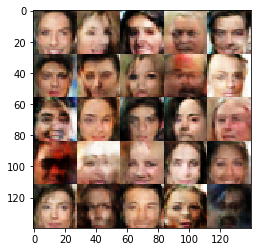

Epoch 1/1 Batch 4410/6331... Discriminator Loss: 0.1919 Generator Loss: 3.8464
Epoch 1/1 Batch 4420/6331... Discriminator Loss: 0.2538 Generator Loss: 3.2764
Epoch 1/1 Batch 4430/6331... Discriminator Loss: 0.3169 Generator Loss: 4.6544
Epoch 1/1 Batch 4440/6331... Discriminator Loss: 0.2367 Generator Loss: 3.6511
Epoch 1/1 Batch 4450/6331... Discriminator Loss: 0.2134 Generator Loss: 2.1627
Epoch 1/1 Batch 4460/6331... Discriminator Loss: 0.8763 Generator Loss: 0.6514
Epoch 1/1 Batch 4470/6331... Discriminator Loss: 0.1961 Generator Loss: 3.0381
Epoch 1/1 Batch 4480/6331... Discriminator Loss: 0.3537 Generator Loss: 3.4775
Epoch 1/1 Batch 4490/6331... Discriminator Loss: 0.5918 Generator Loss: 1.0351
Epoch 1/1 Batch 4500/6331... Discriminator Loss: 0.4464 Generator Loss: 1.4152


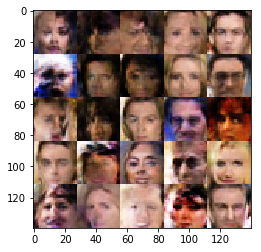

Epoch 1/1 Batch 4510/6331... Discriminator Loss: 0.0970 Generator Loss: 4.7465
Epoch 1/1 Batch 4520/6331... Discriminator Loss: 0.1958 Generator Loss: 2.6262
Epoch 1/1 Batch 4530/6331... Discriminator Loss: 0.2911 Generator Loss: 4.0688
Epoch 1/1 Batch 4540/6331... Discriminator Loss: 0.2805 Generator Loss: 2.5138
Epoch 1/1 Batch 4550/6331... Discriminator Loss: 0.2485 Generator Loss: 2.7509
Epoch 1/1 Batch 4560/6331... Discriminator Loss: 0.3119 Generator Loss: 1.2919
Epoch 1/1 Batch 4570/6331... Discriminator Loss: 0.5803 Generator Loss: 1.4847
Epoch 1/1 Batch 4580/6331... Discriminator Loss: 0.1950 Generator Loss: 2.9952
Epoch 1/1 Batch 4590/6331... Discriminator Loss: 0.3608 Generator Loss: 3.6078
Epoch 1/1 Batch 4600/6331... Discriminator Loss: 0.2299 Generator Loss: 3.4258


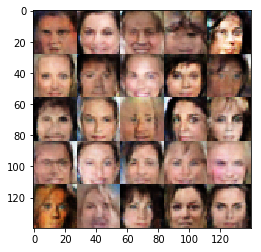

Epoch 1/1 Batch 4610/6331... Discriminator Loss: 0.4927 Generator Loss: 1.7165
Epoch 1/1 Batch 4620/6331... Discriminator Loss: 0.5885 Generator Loss: 1.7581
Epoch 1/1 Batch 4630/6331... Discriminator Loss: 0.1300 Generator Loss: 3.1023
Epoch 1/1 Batch 4640/6331... Discriminator Loss: 0.2156 Generator Loss: 2.6871
Epoch 1/1 Batch 4650/6331... Discriminator Loss: 0.1453 Generator Loss: 3.8846
Epoch 1/1 Batch 4660/6331... Discriminator Loss: 0.1693 Generator Loss: 3.1043
Epoch 1/1 Batch 4670/6331... Discriminator Loss: 0.1992 Generator Loss: 3.0958
Epoch 1/1 Batch 4680/6331... Discriminator Loss: 0.3097 Generator Loss: 3.1644
Epoch 1/1 Batch 4690/6331... Discriminator Loss: 0.4894 Generator Loss: 1.3290
Epoch 1/1 Batch 4700/6331... Discriminator Loss: 0.1519 Generator Loss: 3.3432


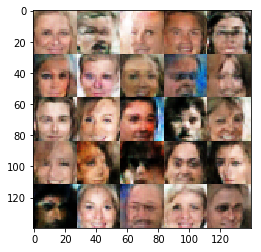

Epoch 1/1 Batch 4710/6331... Discriminator Loss: 0.1068 Generator Loss: 3.2545
Epoch 1/1 Batch 4720/6331... Discriminator Loss: 0.1737 Generator Loss: 3.7488
Epoch 1/1 Batch 4730/6331... Discriminator Loss: 0.2136 Generator Loss: 1.7984
Epoch 1/1 Batch 4740/6331... Discriminator Loss: 0.2577 Generator Loss: 3.0704
Epoch 1/1 Batch 4750/6331... Discriminator Loss: 0.1448 Generator Loss: 3.1435
Epoch 1/1 Batch 4760/6331... Discriminator Loss: 0.1382 Generator Loss: 3.4631
Epoch 1/1 Batch 4770/6331... Discriminator Loss: 1.3572 Generator Loss: 5.1442
Epoch 1/1 Batch 4780/6331... Discriminator Loss: 0.2736 Generator Loss: 3.6308
Epoch 1/1 Batch 4790/6331... Discriminator Loss: 0.1078 Generator Loss: 3.9327
Epoch 1/1 Batch 4800/6331... Discriminator Loss: 0.3938 Generator Loss: 1.8189


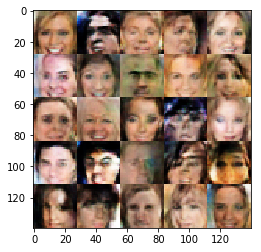

Epoch 1/1 Batch 4810/6331... Discriminator Loss: 0.4150 Generator Loss: 2.2868
Epoch 1/1 Batch 4820/6331... Discriminator Loss: 0.1931 Generator Loss: 2.5518
Epoch 1/1 Batch 4830/6331... Discriminator Loss: 0.3041 Generator Loss: 3.3715
Epoch 1/1 Batch 4840/6331... Discriminator Loss: 0.1535 Generator Loss: 3.8385
Epoch 1/1 Batch 4850/6331... Discriminator Loss: 0.1179 Generator Loss: 3.0603
Epoch 1/1 Batch 4860/6331... Discriminator Loss: 0.1696 Generator Loss: 2.6704
Epoch 1/1 Batch 4870/6331... Discriminator Loss: 0.3222 Generator Loss: 2.6483
Epoch 1/1 Batch 4880/6331... Discriminator Loss: 0.4182 Generator Loss: 3.1176
Epoch 1/1 Batch 4890/6331... Discriminator Loss: 0.8214 Generator Loss: 1.1361
Epoch 1/1 Batch 4900/6331... Discriminator Loss: 0.2632 Generator Loss: 2.7247


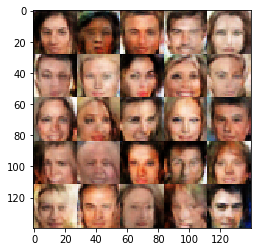

Epoch 1/1 Batch 4910/6331... Discriminator Loss: 0.8386 Generator Loss: 0.9157
Epoch 1/1 Batch 4920/6331... Discriminator Loss: 0.5338 Generator Loss: 1.5606
Epoch 1/1 Batch 4930/6331... Discriminator Loss: 0.7809 Generator Loss: 0.8667
Epoch 1/1 Batch 4940/6331... Discriminator Loss: 0.8262 Generator Loss: 5.2243
Epoch 1/1 Batch 4950/6331... Discriminator Loss: 0.2033 Generator Loss: 3.7310
Epoch 1/1 Batch 4960/6331... Discriminator Loss: 0.4134 Generator Loss: 2.3869
Epoch 1/1 Batch 4970/6331... Discriminator Loss: 0.5926 Generator Loss: 0.8014
Epoch 1/1 Batch 4980/6331... Discriminator Loss: 0.2282 Generator Loss: 3.5736
Epoch 1/1 Batch 4990/6331... Discriminator Loss: 0.1982 Generator Loss: 3.6611
Epoch 1/1 Batch 5000/6331... Discriminator Loss: 0.3595 Generator Loss: 3.6217


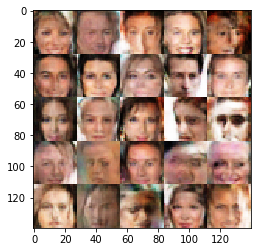

Epoch 1/1 Batch 5010/6331... Discriminator Loss: 0.3100 Generator Loss: 2.1608
Epoch 1/1 Batch 5020/6331... Discriminator Loss: 0.3288 Generator Loss: 2.3033
Epoch 1/1 Batch 5030/6331... Discriminator Loss: 0.3050 Generator Loss: 1.8299
Epoch 1/1 Batch 5040/6331... Discriminator Loss: 0.8548 Generator Loss: 5.6172
Epoch 1/1 Batch 5050/6331... Discriminator Loss: 0.2009 Generator Loss: 2.6408
Epoch 1/1 Batch 5060/6331... Discriminator Loss: 0.1564 Generator Loss: 4.0632
Epoch 1/1 Batch 5070/6331... Discriminator Loss: 0.2115 Generator Loss: 3.0455
Epoch 1/1 Batch 5080/6331... Discriminator Loss: 0.2301 Generator Loss: 4.7760
Epoch 1/1 Batch 5090/6331... Discriminator Loss: 0.4271 Generator Loss: 2.0129
Epoch 1/1 Batch 5100/6331... Discriminator Loss: 1.3033 Generator Loss: 6.4960


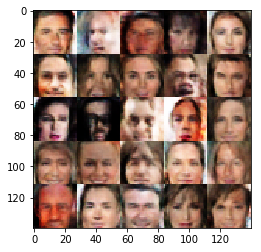

Epoch 1/1 Batch 5110/6331... Discriminator Loss: 0.3370 Generator Loss: 1.5908
Epoch 1/1 Batch 5120/6331... Discriminator Loss: 0.1762 Generator Loss: 3.3265
Epoch 1/1 Batch 5130/6331... Discriminator Loss: 0.2316 Generator Loss: 2.1514
Epoch 1/1 Batch 5140/6331... Discriminator Loss: 0.3688 Generator Loss: 2.7110
Epoch 1/1 Batch 5150/6331... Discriminator Loss: 0.3282 Generator Loss: 1.6465
Epoch 1/1 Batch 5160/6331... Discriminator Loss: 0.2140 Generator Loss: 1.8969
Epoch 1/1 Batch 5170/6331... Discriminator Loss: 0.3831 Generator Loss: 1.5149
Epoch 1/1 Batch 5180/6331... Discriminator Loss: 0.1879 Generator Loss: 3.5095
Epoch 1/1 Batch 5190/6331... Discriminator Loss: 0.2354 Generator Loss: 2.4585
Epoch 1/1 Batch 5200/6331... Discriminator Loss: 0.1668 Generator Loss: 3.0056


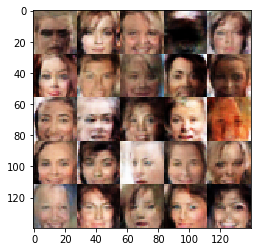

Epoch 1/1 Batch 5210/6331... Discriminator Loss: 0.2107 Generator Loss: 2.2029
Epoch 1/1 Batch 5220/6331... Discriminator Loss: 0.1619 Generator Loss: 2.6177
Epoch 1/1 Batch 5230/6331... Discriminator Loss: 0.6524 Generator Loss: 1.2015
Epoch 1/1 Batch 5240/6331... Discriminator Loss: 0.2648 Generator Loss: 1.8091
Epoch 1/1 Batch 5250/6331... Discriminator Loss: 0.2038 Generator Loss: 2.0608
Epoch 1/1 Batch 5260/6331... Discriminator Loss: 0.2880 Generator Loss: 3.8080
Epoch 1/1 Batch 5270/6331... Discriminator Loss: 0.1658 Generator Loss: 2.0934
Epoch 1/1 Batch 5280/6331... Discriminator Loss: 0.3220 Generator Loss: 2.7397
Epoch 1/1 Batch 5290/6331... Discriminator Loss: 0.8834 Generator Loss: 1.1749
Epoch 1/1 Batch 5300/6331... Discriminator Loss: 0.1932 Generator Loss: 4.3245


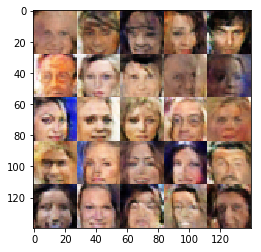

Epoch 1/1 Batch 5310/6331... Discriminator Loss: 0.2798 Generator Loss: 3.0395
Epoch 1/1 Batch 5320/6331... Discriminator Loss: 0.1712 Generator Loss: 2.4181
Epoch 1/1 Batch 5330/6331... Discriminator Loss: 0.2234 Generator Loss: 2.0753
Epoch 1/1 Batch 5340/6331... Discriminator Loss: 0.6327 Generator Loss: 1.3640
Epoch 1/1 Batch 5350/6331... Discriminator Loss: 0.2003 Generator Loss: 3.2346
Epoch 1/1 Batch 5360/6331... Discriminator Loss: 2.4799 Generator Loss: 0.1329
Epoch 1/1 Batch 5370/6331... Discriminator Loss: 0.2217 Generator Loss: 3.2738
Epoch 1/1 Batch 5380/6331... Discriminator Loss: 0.2751 Generator Loss: 3.5455
Epoch 1/1 Batch 5390/6331... Discriminator Loss: 0.2604 Generator Loss: 2.6316
Epoch 1/1 Batch 5400/6331... Discriminator Loss: 0.1331 Generator Loss: 3.0747


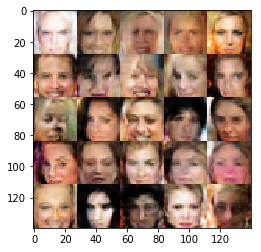

Epoch 1/1 Batch 5410/6331... Discriminator Loss: 0.1222 Generator Loss: 3.6695
Epoch 1/1 Batch 5420/6331... Discriminator Loss: 0.1478 Generator Loss: 3.2733
Epoch 1/1 Batch 5430/6331... Discriminator Loss: 0.1294 Generator Loss: 4.3103
Epoch 1/1 Batch 5440/6331... Discriminator Loss: 0.2335 Generator Loss: 2.6254
Epoch 1/1 Batch 5450/6331... Discriminator Loss: 0.3101 Generator Loss: 1.9439
Epoch 1/1 Batch 5460/6331... Discriminator Loss: 0.2006 Generator Loss: 1.8662
Epoch 1/1 Batch 5470/6331... Discriminator Loss: 0.1756 Generator Loss: 3.8218
Epoch 1/1 Batch 5480/6331... Discriminator Loss: 0.2100 Generator Loss: 2.6438
Epoch 1/1 Batch 5490/6331... Discriminator Loss: 0.2152 Generator Loss: 2.3762
Epoch 1/1 Batch 5500/6331... Discriminator Loss: 0.1692 Generator Loss: 2.7831


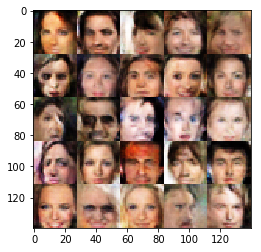

Epoch 1/1 Batch 5510/6331... Discriminator Loss: 0.3619 Generator Loss: 1.9743
Epoch 1/1 Batch 5520/6331... Discriminator Loss: 0.1747 Generator Loss: 3.1265
Epoch 1/1 Batch 5530/6331... Discriminator Loss: 0.4144 Generator Loss: 1.4183
Epoch 1/1 Batch 5540/6331... Discriminator Loss: 0.2046 Generator Loss: 2.1756
Epoch 1/1 Batch 5550/6331... Discriminator Loss: 0.1998 Generator Loss: 2.3009
Epoch 1/1 Batch 5560/6331... Discriminator Loss: 0.1652 Generator Loss: 2.9243
Epoch 1/1 Batch 5570/6331... Discriminator Loss: 0.2588 Generator Loss: 5.5765
Epoch 1/1 Batch 5580/6331... Discriminator Loss: 0.2136 Generator Loss: 2.3793
Epoch 1/1 Batch 5590/6331... Discriminator Loss: 0.1663 Generator Loss: 2.5575
Epoch 1/1 Batch 5600/6331... Discriminator Loss: 0.1423 Generator Loss: 3.0326


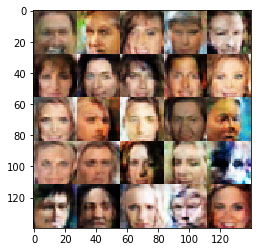

Epoch 1/1 Batch 5610/6331... Discriminator Loss: 0.3925 Generator Loss: 1.5930
Epoch 1/1 Batch 5620/6331... Discriminator Loss: 0.2344 Generator Loss: 2.8966
Epoch 1/1 Batch 5630/6331... Discriminator Loss: 0.2268 Generator Loss: 4.6819
Epoch 1/1 Batch 5640/6331... Discriminator Loss: 0.2474 Generator Loss: 3.6187
Epoch 1/1 Batch 5650/6331... Discriminator Loss: 0.4510 Generator Loss: 2.0706
Epoch 1/1 Batch 5660/6331... Discriminator Loss: 0.1526 Generator Loss: 4.4285
Epoch 1/1 Batch 5670/6331... Discriminator Loss: 0.1272 Generator Loss: 3.2872
Epoch 1/1 Batch 5680/6331... Discriminator Loss: 0.2963 Generator Loss: 3.2557
Epoch 1/1 Batch 5690/6331... Discriminator Loss: 0.3031 Generator Loss: 2.1734
Epoch 1/1 Batch 5700/6331... Discriminator Loss: 0.2090 Generator Loss: 2.6936


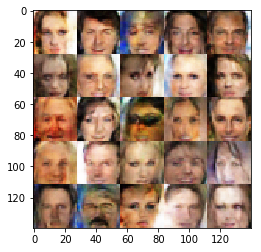

Epoch 1/1 Batch 5710/6331... Discriminator Loss: 0.1873 Generator Loss: 4.0537
Epoch 1/1 Batch 5720/6331... Discriminator Loss: 0.6494 Generator Loss: 4.8319
Epoch 1/1 Batch 5730/6331... Discriminator Loss: 0.3941 Generator Loss: 3.0045
Epoch 1/1 Batch 5740/6331... Discriminator Loss: 0.1777 Generator Loss: 4.2436
Epoch 1/1 Batch 5750/6331... Discriminator Loss: 0.4597 Generator Loss: 1.2523
Epoch 1/1 Batch 5760/6331... Discriminator Loss: 0.4283 Generator Loss: 1.6279
Epoch 1/1 Batch 5770/6331... Discriminator Loss: 0.2071 Generator Loss: 3.2985
Epoch 1/1 Batch 5780/6331... Discriminator Loss: 0.2551 Generator Loss: 2.7739
Epoch 1/1 Batch 5790/6331... Discriminator Loss: 0.3239 Generator Loss: 2.5994
Epoch 1/1 Batch 5800/6331... Discriminator Loss: 0.4209 Generator Loss: 1.6531


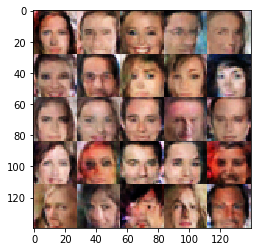

Epoch 1/1 Batch 5810/6331... Discriminator Loss: 0.2654 Generator Loss: 2.8673
Epoch 1/1 Batch 5820/6331... Discriminator Loss: 0.2415 Generator Loss: 2.9253
Epoch 1/1 Batch 5830/6331... Discriminator Loss: 0.3376 Generator Loss: 4.5450
Epoch 1/1 Batch 5840/6331... Discriminator Loss: 0.1401 Generator Loss: 4.3742
Epoch 1/1 Batch 5850/6331... Discriminator Loss: 0.2464 Generator Loss: 2.6639
Epoch 1/1 Batch 5860/6331... Discriminator Loss: 0.2111 Generator Loss: 2.7624
Epoch 1/1 Batch 5870/6331... Discriminator Loss: 0.2867 Generator Loss: 2.0640
Epoch 1/1 Batch 5880/6331... Discriminator Loss: 0.3382 Generator Loss: 5.2846
Epoch 1/1 Batch 5890/6331... Discriminator Loss: 0.1668 Generator Loss: 3.5795
Epoch 1/1 Batch 5900/6331... Discriminator Loss: 0.1694 Generator Loss: 2.3143


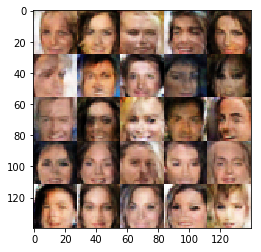

Epoch 1/1 Batch 5910/6331... Discriminator Loss: 0.0886 Generator Loss: 3.7172
Epoch 1/1 Batch 5920/6331... Discriminator Loss: 0.0787 Generator Loss: 4.5157
Epoch 1/1 Batch 5930/6331... Discriminator Loss: 0.0955 Generator Loss: 4.0526
Epoch 1/1 Batch 5940/6331... Discriminator Loss: 0.3903 Generator Loss: 1.5408
Epoch 1/1 Batch 5950/6331... Discriminator Loss: 0.2145 Generator Loss: 2.1863
Epoch 1/1 Batch 5960/6331... Discriminator Loss: 0.1787 Generator Loss: 3.0929
Epoch 1/1 Batch 5970/6331... Discriminator Loss: 0.1873 Generator Loss: 3.0303
Epoch 1/1 Batch 5980/6331... Discriminator Loss: 0.4812 Generator Loss: 2.3025
Epoch 1/1 Batch 5990/6331... Discriminator Loss: 0.1728 Generator Loss: 3.3630
Epoch 1/1 Batch 6000/6331... Discriminator Loss: 0.2277 Generator Loss: 2.0985


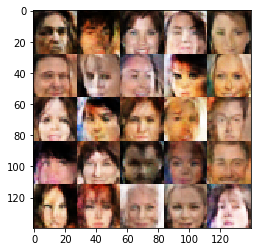

Epoch 1/1 Batch 6010/6331... Discriminator Loss: 0.1313 Generator Loss: 3.1537
Epoch 1/1 Batch 6020/6331... Discriminator Loss: 0.1963 Generator Loss: 2.6265
Epoch 1/1 Batch 6030/6331... Discriminator Loss: 0.2640 Generator Loss: 2.2373
Epoch 1/1 Batch 6040/6331... Discriminator Loss: 0.2039 Generator Loss: 2.7691
Epoch 1/1 Batch 6050/6331... Discriminator Loss: 0.2361 Generator Loss: 1.9353
Epoch 1/1 Batch 6060/6331... Discriminator Loss: 0.1632 Generator Loss: 3.1422
Epoch 1/1 Batch 6070/6331... Discriminator Loss: 0.3519 Generator Loss: 2.0225
Epoch 1/1 Batch 6080/6331... Discriminator Loss: 0.3300 Generator Loss: 3.4208
Epoch 1/1 Batch 6090/6331... Discriminator Loss: 0.1930 Generator Loss: 2.6193
Epoch 1/1 Batch 6100/6331... Discriminator Loss: 0.1181 Generator Loss: 2.1040


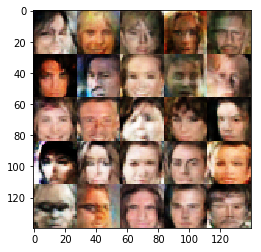

Epoch 1/1 Batch 6110/6331... Discriminator Loss: 0.7245 Generator Loss: 1.6732
Epoch 1/1 Batch 6120/6331... Discriminator Loss: 0.1885 Generator Loss: 2.6136
Epoch 1/1 Batch 6130/6331... Discriminator Loss: 0.1271 Generator Loss: 3.4346
Epoch 1/1 Batch 6140/6331... Discriminator Loss: 0.2245 Generator Loss: 2.3038
Epoch 1/1 Batch 6150/6331... Discriminator Loss: 0.0916 Generator Loss: 4.6128
Epoch 1/1 Batch 6160/6331... Discriminator Loss: 0.1440 Generator Loss: 3.5649
Epoch 1/1 Batch 6170/6331... Discriminator Loss: 0.4887 Generator Loss: 1.3626
Epoch 1/1 Batch 6180/6331... Discriminator Loss: 0.1423 Generator Loss: 3.1802
Epoch 1/1 Batch 6190/6331... Discriminator Loss: 0.0676 Generator Loss: 4.3896
Epoch 1/1 Batch 6200/6331... Discriminator Loss: 0.2715 Generator Loss: 2.1277


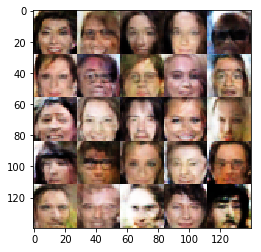

Epoch 1/1 Batch 6210/6331... Discriminator Loss: 0.2142 Generator Loss: 2.5970
Epoch 1/1 Batch 6220/6331... Discriminator Loss: 0.1659 Generator Loss: 3.0674
Epoch 1/1 Batch 6230/6331... Discriminator Loss: 0.1384 Generator Loss: 3.8434
Epoch 1/1 Batch 6240/6331... Discriminator Loss: 0.1837 Generator Loss: 2.8941
Epoch 1/1 Batch 6250/6331... Discriminator Loss: 0.1971 Generator Loss: 3.7335
Epoch 1/1 Batch 6260/6331... Discriminator Loss: 0.1824 Generator Loss: 3.5964
Epoch 1/1 Batch 6270/6331... Discriminator Loss: 0.1157 Generator Loss: 3.3322
Epoch 1/1 Batch 6280/6331... Discriminator Loss: 0.1616 Generator Loss: 5.6154
Epoch 1/1 Batch 6290/6331... Discriminator Loss: 0.2524 Generator Loss: 2.1832
Epoch 1/1 Batch 6300/6331... Discriminator Loss: 0.7065 Generator Loss: 5.3709


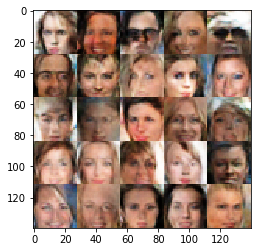

Epoch 1/1 Batch 6310/6331... Discriminator Loss: 0.1501 Generator Loss: 2.9733
Epoch 1/1 Batch 6320/6331... Discriminator Loss: 0.2334 Generator Loss: 5.5833
Epoch 1/1 Batch 6330/6331... Discriminator Loss: 0.1606 Generator Loss: 3.3656
Finished!


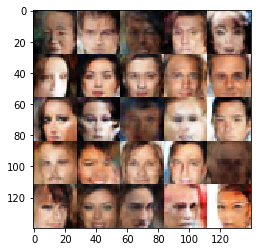

In [14]:
batch_size = 32
z_dim = 128
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.